# CAPSTONE PROJECT    "People Tracking"



# Student


Name:    Roland Unger

Email:   te8@titan-electronic.com

The student is working in the electronic security business. This means CCTV camera surveillance, access control
command and control systems. The student has a lot of experience in this field and want to use a common problem for his capstone project. 

# Idea

People tracking in CCTV stream and analyzing the behavior for further actions in an alarm control system.

# 1.) Business Understanding

In a common CCTV surveillance system an operator is watching abnormal behavior and reacting manually.
If the system is big, lets say 200 cameras, it is hard or unpossible to recognize the attacker.
Therefore a AI-model should filter and select the interesting cameras to the operator monitor.
Furthermore the model could start automatic actions on an alarm control system like:

- Switch the selected cameras to an alarm monitor (multiple camera view on one monitor). 
- Predict the people moving from the last movement and see if the person will go over a specific virtual line (trip wire) in the near future. If so, an action could be released similar to point 1. The prediction gives the operator more time to react on the attacker´s behavior.  
- The predicting function of the model should find the person after covering from an other person in the picture or some other    object in the scene.
- The model should find abnormal behavior of people movement: Change of moving speed (slow to run), abnormal moving

## 1.1) Data Requirement

The input data for the AI-model have to come directly from a AI-camera. AI-cameras have the possibility to classify objects in a camera scene. The most common classifier are people, vehicles and bikes. Such cameras deliver via RTP stream the detection and classification data. 
For the model the following data are required:
- Timestamp of the detection
- Location of the detected object (x and y coordinates)
- Size of the object (bounding box)
- Classification (person, car, bike etc.)


# 2.)  Data Understanding


## 2.1) Sample Data

The following dataset shows an example output of meta data from an AI-camera and will be used for further examination.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import time

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_wine
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from darts.models import KalmanForecaster
from darts import TimeSeries

In [2]:
#pip install movingpandas

In [3]:
#pip install darts

In [4]:
#conda install -c conda-forge -c pytorch u8darts-all

In [5]:
person = pd.read_csv('data/ai_cam_18.csv', sep=';')

In [6]:
person.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID                 3755 non-null   int64
 1   Length             3755 non-null   int64
 2   Utcclk             3755 non-null   int64
 3   TimeZoneDirection  3755 non-null   int64
 4   SummerTime         3755 non-null   bool 
 5   TimeZoneHour       3755 non-null   int64
 6   FrameTime          3755 non-null   int64
 7   AlgorithmId        3755 non-null   int64
 8   UniqueInfoFlag     3755 non-null   int64
 9   ResultInfoFlag     3755 non-null   int64
 10  ResultInfoLength   3755 non-null   int64
 11  AreaNum            3755 non-null   int64
 12  AreaLength         3755 non-null   int64
 13  ImageWidth         3755 non-null   int64
 14  ImageHeight        3755 non-null   int64
 15  AreaId             3755 non-null   int64
 16  DtctArea           3755 non-null   int64
 17  AlmType       

In [7]:
person.head()

,ID,Length,Utcclk,TimeZoneDirection,SummerTime,TimeZoneHour,FrameTime,AlgorithmId,UniqueInfoFlag,ResultInfoFlag,...,ImageHeight,AreaId,DtctArea,AlmType,Dir,AlmObj,Hstart,Vstart,Hcnt,Vcnt
0,47,40,1700567040,0,False,0,78,256,0,1,...,450,3855,0,15,0,4,490,177,60,180
1,47,40,1700567040,0,False,0,81,256,0,1,...,450,3855,0,15,0,4,490,177,60,180
2,47,40,1700567040,0,False,0,84,256,0,1,...,450,3855,0,15,0,4,490,177,60,180
3,47,40,1700567040,0,False,0,88,256,0,1,...,450,3855,0,15,0,4,490,177,60,180
4,47,40,1700567040,0,False,0,91,256,0,1,...,450,3855,0,15,0,4,490,177,60,180


In [8]:
person.tail()

,ID,Length,Utcclk,TimeZoneDirection,SummerTime,TimeZoneHour,FrameTime,AlgorithmId,UniqueInfoFlag,ResultInfoFlag,...,ImageHeight,AreaId,DtctArea,AlmType,Dir,AlmObj,Hstart,Vstart,Hcnt,Vcnt
3750,47,40,1700567170,0,False,0,54,256,0,1,...,450,4101,1,1,0,1,472,175,65,185
3751,47,40,1700567170,0,False,0,58,256,0,1,...,450,4101,1,1,0,1,472,175,65,185
3752,47,40,1700567170,0,False,0,61,256,0,1,...,450,4101,1,1,0,1,472,175,67,185
3753,47,40,1700567170,0,False,0,64,256,0,1,...,450,4101,1,1,0,1,472,175,67,185
3754,47,40,1700567170,0,False,0,68,256,0,1,...,450,4101,1,1,0,1,472,175,67,185


## 2.2) Findings
- The required data are in the dataset
- There are some more data which are not interested
- The following data are selected for further use:<br>

     FrameTime &emsp;...&emsp; gives the detection data in 10ms, goes from 0x0 to 0x63 = 990ms <br>
     AlmObj &emsp;&emsp;&nbsp;&nbsp;&nbsp;...&emsp; output of the object classificator <br>
     Hstart &emsp;&emsp;&emsp;&nbsp;   ...&emsp; left up corner x-coordinate of the object <br>
     Vstart &emsp;&emsp;&emsp;&nbsp;   ...&emsp; left up corner y-coordinate of the object <br>
     Hcnt  &emsp;&emsp;&emsp;&emsp;     ...&emsp; object x size in pixel of detection area (320 pixel) <br>
     Vcnt  &emsp;&emsp;&emsp;&emsp;     ...&emsp; object y size in pixel of detection area (240 pixel) <br>

# 3.) Data Preparation
In the dataset are some more not relevant data columns. Furthermore there are detection data from none person objects.
Only person objects will be used.

In [9]:
# filter only humans AlmObj == 1
person = person[person['AlmObj'] == 1]

In [10]:
# Show the most relevant data for the project

# FrameTime ... gives the detection data in 10ms, goes from 0x0 to 0x63 = 990ms
# AlmObj    ... output of the object classificator
# Hstart    ... left up corner x-coordinate of the object
# Vstart    ... left up corner y-coordinate of the object
# Hcnt      ... object x size in pixel of detection area (320x240 resolution)
# Vcnt      ... object y size in pixel ----- "--------"

data = person[['FrameTime', 'AlmObj','Hstart','Vstart','Hcnt','Vcnt', 'Utcclk']].iloc[:400,:7]

In [11]:
data.head(10)

,FrameTime,AlmObj,Hstart,Vstart,Hcnt,Vcnt,Utcclk
109,84,1,425,172,102,182,1700567044
110,88,1,425,172,102,182,1700567044
111,91,1,425,175,107,180,1700567044
112,94,1,425,175,107,180,1700567044
113,98,1,425,175,107,180,1700567044
114,1,1,425,175,107,180,1700567045
115,4,1,425,177,110,175,1700567045
116,8,1,425,177,110,175,1700567045
117,11,1,422,180,105,172,1700567045
118,14,1,422,180,105,172,1700567045


In [12]:
data.describe()

,FrameTime,AlmObj,Hstart,Vstart,Hcnt,Vcnt,Utcclk
count,400.0000,400.0,400.000000,400.000000,400.000000,400.000000,4.000000e+02
mean,49.5750,1.0,437.215000,78.420000,42.362500,166.295000,1.700567e+09
std,29.7617,0.0,118.279219,25.880845,18.633279,57.286931,4.394197e+00
min,1.0000,1.0,222.000000,60.000000,25.000000,115.000000,1.700567e+09
25%,24.0000,1.0,332.000000,65.000000,32.000000,122.000000,1.700567e+09
50%,49.5000,1.0,472.000000,67.000000,32.000000,135.000000,1.700567e+09
75%,75.0000,1.0,550.000000,77.000000,55.000000,205.500000,1.700567e+09
max,98.0000,1.0,562.000000,180.000000,110.000000,277.000000,1.700567e+09


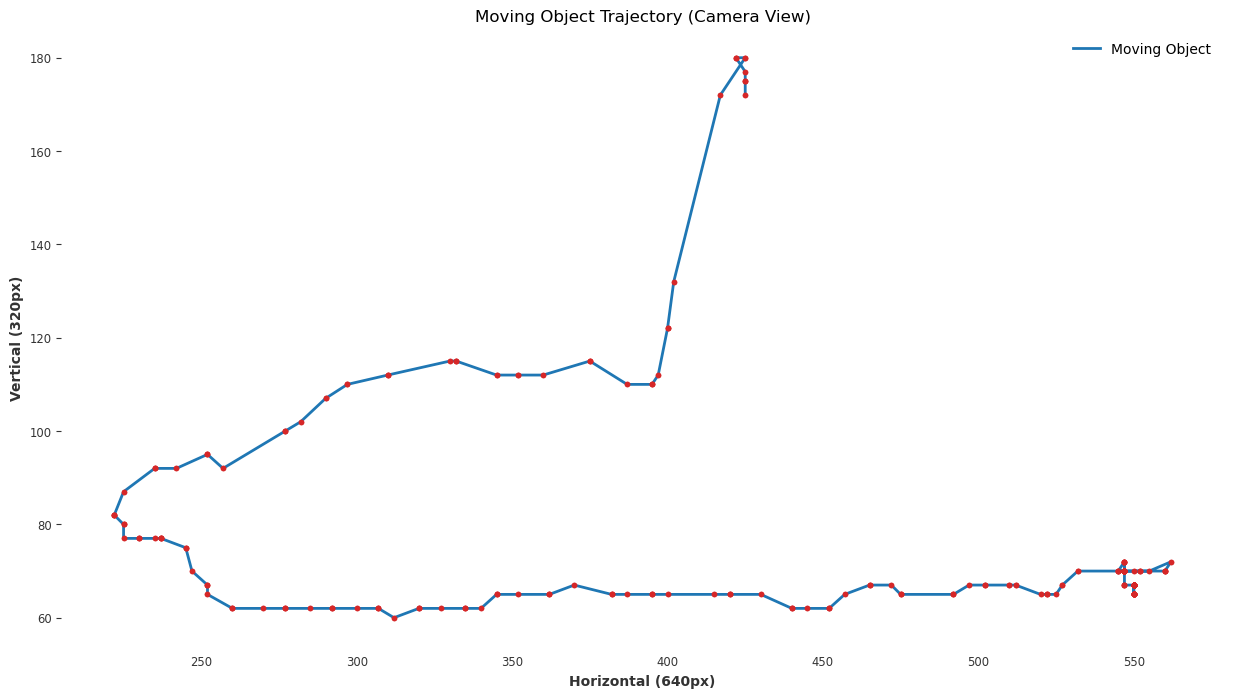

In [13]:
# Generate a line plot with two vectors 
# The columns 'Hstart' and 'Vstart' save the 2D coordinates of the moving object on a specific timeslot
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
ax.plot(data['Hstart'], data['Vstart'], '-', color='tab:blue', lw=2, label='Moving Object')
ax.plot(data['Hstart'], data['Vstart'], '.', color='tab:red')
ax.grid()
ax.set_title('Moving Object Trajectory (Camera View)')
ax.set(xlabel='Horizontal (640px)', ylabel='Vertical (320px)')
ax.legend(loc='upper right')
plt.show()

### Moving Pandas plotting 
Moving pandas is a special library for trajectory applications. Let´s see what we can learn from our data with this library.

In [14]:
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts

In [15]:
# compute point for the moving panda dataframe usage
# add two new columns 'geometry' and 'timestamp' to the dataset
# init the new datafields
for i in range (len(data)):
    data['geometry']  = 0.0
    data['timestamp'] = 0.0

In [16]:
# compute the new columns from the original data 'Hstart' and 'Vstart' to get a point and 
# from 'Utcclk' and 'FrameTime' to get a timestamp. The 'Utcclk' is coming in seconds and 'FrameTime' in 10ms steps.
# Therefore we have to do some tranformation to get an datetime including the FrameTime. 
# For easy use of the timestamp the author normalize the time to the first row.
start_time = data['Utcclk'].iloc[0]*1000000000
for i in range (len(data)):
    data['geometry'].iloc[i]  = Point(data['Hstart'].iloc[i], data['Vstart'].iloc[i])
    data['timestamp'].iloc[i] = pd.to_datetime(data['Utcclk'].iloc[i]*1000000000 + data['FrameTime'].iloc[i]*10000000 - start_time) 
    if i < 3 :    
        print('FrameTime   : ',data['FrameTime'].iloc[i]*10000000)
        print('Utcclk      : ',data['Utcclk'].iloc[i]*1000000000)
        print('Total       : ',data['timestamp'].iloc[i])
        print()

FrameTime   :  840000000
Utcclk      :  1700567044000000000
Total       :  1970-01-01 00:00:00.840000

FrameTime   :  880000000
Utcclk      :  1700567044000000000
Total       :  1970-01-01 00:00:00.880000

FrameTime   :  910000000
Utcclk      :  1700567044000000000
Total       :  1970-01-01 00:00:00.910000



In [17]:
data.head(30)

,FrameTime,AlmObj,Hstart,Vstart,Hcnt,Vcnt,Utcclk,geometry,timestamp
109,84,1,425,172,102,182,1700567044,POINT (425 172),1970-01-01 00:00:00.840000
110,88,1,425,172,102,182,1700567044,POINT (425 172),1970-01-01 00:00:00.880000
111,91,1,425,175,107,180,1700567044,POINT (425 175),1970-01-01 00:00:00.910000
112,94,1,425,175,107,180,1700567044,POINT (425 175),1970-01-01 00:00:00.940000
113,98,1,425,175,107,180,1700567044,POINT (425 175),1970-01-01 00:00:00.980000
114,1,1,425,175,107,180,1700567045,POINT (425 175),1970-01-01 00:00:01.010000
115,4,1,425,177,110,175,1700567045,POINT (425 177),1970-01-01 00:00:01.040000
116,8,1,425,177,110,175,1700567045,POINT (425 177),1970-01-01 00:00:01.080000
117,11,1,422,180,105,172,1700567045,POINT (422 180),1970-01-01 00:00:01.110000
118,14,1,422,180,105,172,1700567045,POINT (422 180),1970-01-01 00:00:01.140000


In [18]:
# set the index to the 'timestamp'
data = data.set_index(pd.DatetimeIndex(data['timestamp']))

In [19]:
# drop the unused columns
data.drop({'FrameTime', 'Hcnt', 'Vcnt', 'Utcclk', 'AlmObj'}, axis=1, inplace=True)
# rename columns
data.rename({'Hstart': 'X', 'Vstart' : 'Y'}, axis = 1, inplace=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400 entries, 1970-01-01 00:00:00.840000 to 1970-01-01 00:00:15.780000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   X          400 non-null    int64 
 1   Y          400 non-null    int64 
 2   geometry   400 non-null    object
 3   timestamp  400 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.6+ KB


In [21]:
# generate a GeoDataFrame from our dataset to further generate a trajectory class
data_gdf = GeoDataFrame(data, crs=31256)
toy_traj = mpd.Trajectory(data_gdf, 1)
toy_traj

Trajectory 1 (1970-01-01 00:00:00.840000 to 1970-01-01 00:00:15.780000) | Size: 400 | Length: 677.9m
Bounds: (222.0, 60.0, 562.0, 180.0)
LINESTRING (425 172, 425 172, 425 175, 425 175, 425 175, 425 175, 425 177, 425 177, 422 180, 422 180

In [22]:
# add a direction column to our dataframe
toy_traj.add_direction(overwrite=True)
toy_traj.df

,X,Y,geometry,timestamp,traj_id,direction
timestamp,,,,,,
1970-01-01 00:00:00.840,425,172,POINT (425.000 172.000),1970-01-01 00:00:00.840000,1,0.0
1970-01-01 00:00:00.880,425,172,POINT (425.000 172.000),1970-01-01 00:00:00.880000,1,0.0
1970-01-01 00:00:00.910,425,175,POINT (425.000 175.000),1970-01-01 00:00:00.910000,1,0.0
1970-01-01 00:00:00.940,425,175,POINT (425.000 175.000),1970-01-01 00:00:00.940000,1,0.0
1970-01-01 00:00:00.980,425,175,POINT (425.000 175.000),1970-01-01 00:00:00.980000,1,0.0
...,...,...,...,...,...,...
1970-01-01 00:00:15.640,550,67,POINT (550.000 67.000),1970-01-01 00:00:15.640000,1,0.0
1970-01-01 00:00:15.680,550,67,POINT (550.000 67.000),1970-01-01 00:00:15.680000,1,0.0
1970-01-01 00:00:15.710,550,67,POINT (550.000 67.000),1970-01-01 00:00:15.710000,1,0.0


In [23]:
# add a timedelta between the rows and added to our dataset
toy_traj.add_timedelta(overwrite=True)
# drop the row where is NaT (not a time), coming from the delta time
toy_traj.df.dropna(inplace=True)
toy_traj.df

,X,Y,geometry,timestamp,traj_id,direction,timedelta
timestamp,,,,,,,
1970-01-01 00:00:00.880,425,172,POINT (425.000 172.000),1970-01-01 00:00:00.880000,1,0.0,0 days 00:00:00.040000
1970-01-01 00:00:00.910,425,175,POINT (425.000 175.000),1970-01-01 00:00:00.910000,1,0.0,0 days 00:00:00.030000
1970-01-01 00:00:00.940,425,175,POINT (425.000 175.000),1970-01-01 00:00:00.940000,1,0.0,0 days 00:00:00.030000
1970-01-01 00:00:00.980,425,175,POINT (425.000 175.000),1970-01-01 00:00:00.980000,1,0.0,0 days 00:00:00.040000
1970-01-01 00:00:01.010,425,175,POINT (425.000 175.000),1970-01-01 00:00:01.010000,1,0.0,0 days 00:00:00.030000
...,...,...,...,...,...,...,...
1970-01-01 00:00:15.640,550,67,POINT (550.000 67.000),1970-01-01 00:00:15.640000,1,0.0,0 days 00:00:00.030000
1970-01-01 00:00:15.680,550,67,POINT (550.000 67.000),1970-01-01 00:00:15.680000,1,0.0,0 days 00:00:00.040000
1970-01-01 00:00:15.710,550,67,POINT (550.000 67.000),1970-01-01 00:00:15.710000,1,0.0,0 days 00:00:00.030000


In [24]:
# px stand for pixel
toy_traj.add_distance(overwrite=True, name="distance (px)", units="m")
#toy_traj.add_distance(overwrite=True, name="distance (yards)", units="yd")
toy_traj.add_speed(overwrite=True, name="speed (px/sec)", units=("m", "s"))
#toy_traj.add_speed(overwrite=True, name="speed (knots)", units=("nm", "h"))
toy_traj.add_acceleration(overwrite=True, name="acceleration (px/sec)", units=("mi", "h", "s"))
toy_traj.df

,X,Y,geometry,timestamp,traj_id,direction,timedelta,distance (px),speed (px/sec),acceleration (px/sec)
timestamp,,,,,,,,,,
1970-01-01 00:00:00.880,425,172,POINT (425.000 172.000),1970-01-01 00:00:00.880000,1,0.0,0 days 00:00:00.040000,0.0,100.0,0.000000
1970-01-01 00:00:00.910,425,175,POINT (425.000 175.000),1970-01-01 00:00:00.910000,1,0.0,0 days 00:00:00.030000,3.0,100.0,0.000000
1970-01-01 00:00:00.940,425,175,POINT (425.000 175.000),1970-01-01 00:00:00.940000,1,0.0,0 days 00:00:00.030000,0.0,0.0,-7456.454307
1970-01-01 00:00:00.980,425,175,POINT (425.000 175.000),1970-01-01 00:00:00.980000,1,0.0,0 days 00:00:00.040000,0.0,0.0,0.000000
1970-01-01 00:00:01.010,425,175,POINT (425.000 175.000),1970-01-01 00:00:01.010000,1,0.0,0 days 00:00:00.030000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:15.640,550,67,POINT (550.000 67.000),1970-01-01 00:00:15.640000,1,0.0,0 days 00:00:00.030000,0.0,0.0,0.000000
1970-01-01 00:00:15.680,550,67,POINT (550.000 67.000),1970-01-01 00:00:15.680000,1,0.0,0 days 00:00:00.040000,0.0,0.0,0.000000
1970-01-01 00:00:15.710,550,67,POINT (550.000 67.000),1970-01-01 00:00:15.710000,1,0.0,0 days 00:00:00.030000,0.0,0.0,0.000000


In [25]:
toy_traj.df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 399 entries, 1970-01-01 00:00:00.880000 to 1970-01-01 00:00:15.780000
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   X                      399 non-null    int64          
 1   Y                      399 non-null    int64          
 2   geometry               399 non-null    geometry       
 3   timestamp              399 non-null    object         
 4   traj_id                399 non-null    int64          
 5   direction              399 non-null    float64        
 6   timedelta              399 non-null    timedelta64[ns]
 7   distance (px)          399 non-null    float64        
 8   speed (px/sec)         399 non-null    float64        
 9   acceleration (px/sec)  399 non-null    float64        
dtypes: float64(4), geometry(1), int64(3), object(1), timedelta64[ns](1)
memory usage: 50.5+ KB


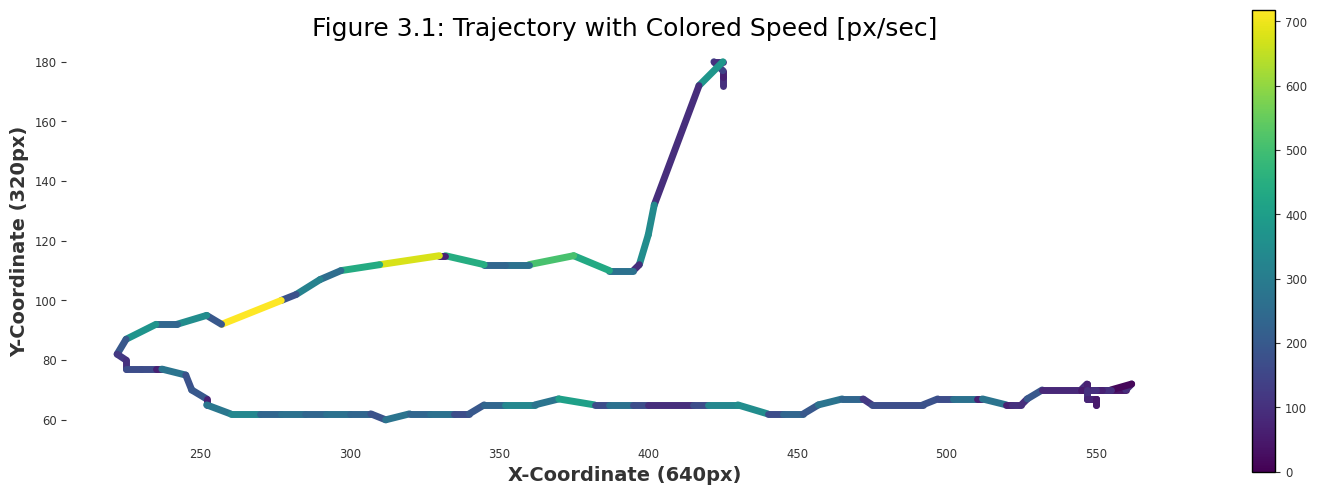

In [26]:
# plot the trajectory with different speed colors
toy_traj.plot(column="speed (px/sec)", linewidth=5, figsize=(18,6), capstyle='round', legend=True)
plt.grid()
plt.xlabel('X-Coordinate (640px)', {'fontsize':14})
plt.ylabel('Y-Coordinate (320px)', {'fontsize':14})
plt.title('Figure 3.1: Trajectory with Colored Speed [px/sec]',  {'fontsize':18})
plt.legend('')

In [27]:
data = toy_traj.df

### Split the Moving in y and x component
The object is moving in a 2 dimension area. For further use in a model the two dimension have to be exermined separately.
Do some plots to see the difference.

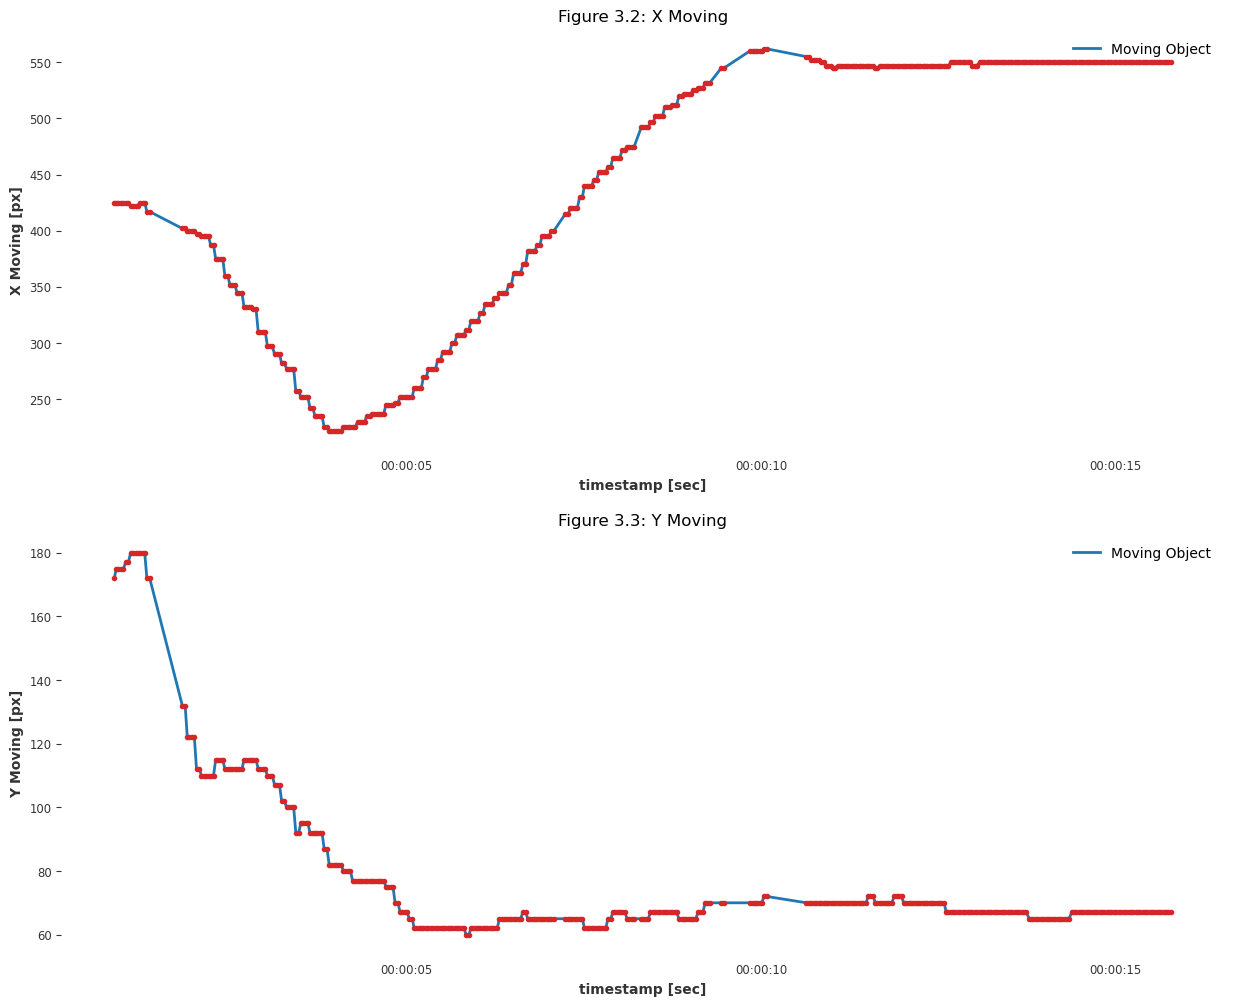

In [28]:
# Generate a line plot with two vectors 
# The columns 'Hstart' and 'Vstart' save the 2D coordinates of the moving object on a specific timeslot
fig, ax = plt.subplots(2, 1, figsize = (15, 12))
ax[0].plot(data['timestamp'], data['X'], '-', color='tab:blue', lw=2, label='Moving Object')
ax[0].plot(data['timestamp'], data['X'], '.', color='tab:red')
ax[0].grid()
ax[0].set_title('Figure 3.2: X Moving')
ax[0].set(xlabel='timestamp [sec]', ylabel='X Moving [px]')
ax[0].legend(loc='upper right')
ax[1].plot(data['timestamp'], data['Y'], '-', color='tab:blue', lw=2, label='Moving Object')
ax[1].plot(data['timestamp'], data['Y'], '.', color='tab:red')
ax[1].grid()
ax[1].set_title('Figure 3.3: Y Moving')
ax[1].set(xlabel='timestamp [sec]', ylabel='Y Moving [px]')
ax[1].legend(loc='upper right')
plt.show()

### Plot: Speed
Let´s examine the speed values

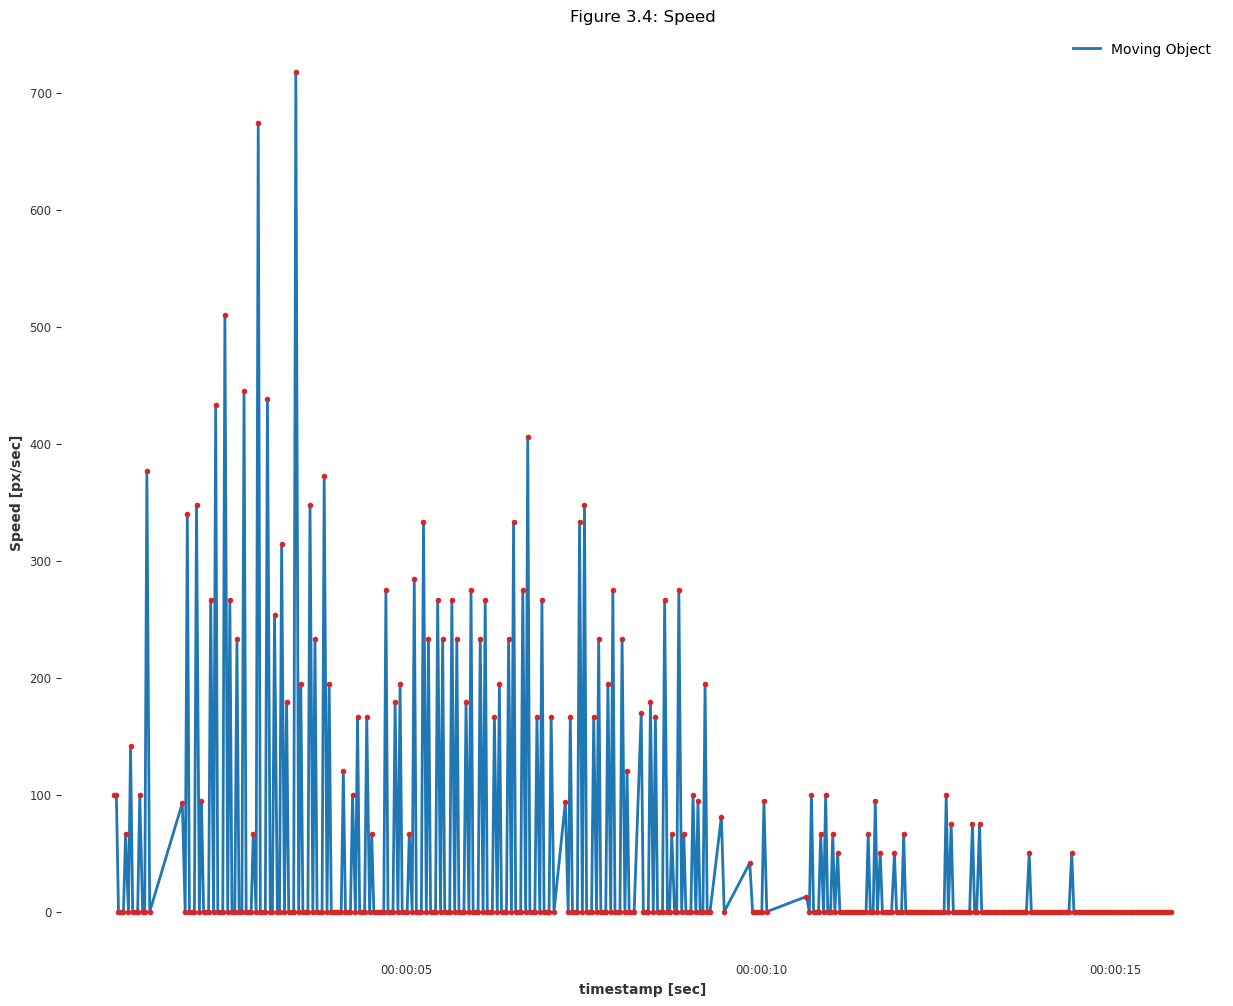

In [29]:
# Generate a line plot with two vectors 
# The columns 'Hstart' and 'Vstart' save the 2D coordinates of the moving object on a specific timeslot
fig, ax = plt.subplots(1, 1, figsize = (15, 12))
ax.plot(data['timestamp'], data['speed (px/sec)'], '-', color='tab:blue', lw=2, label='Moving Object')
ax.plot(data['timestamp'], data['speed (px/sec)'], '.', color='tab:red')
ax.grid()
ax.set_title('Figure 3.4: Speed')
ax.set(xlabel='timestamp [sec]', ylabel='Speed [px/sec]')
ax.legend(loc='upper right')
plt.show()

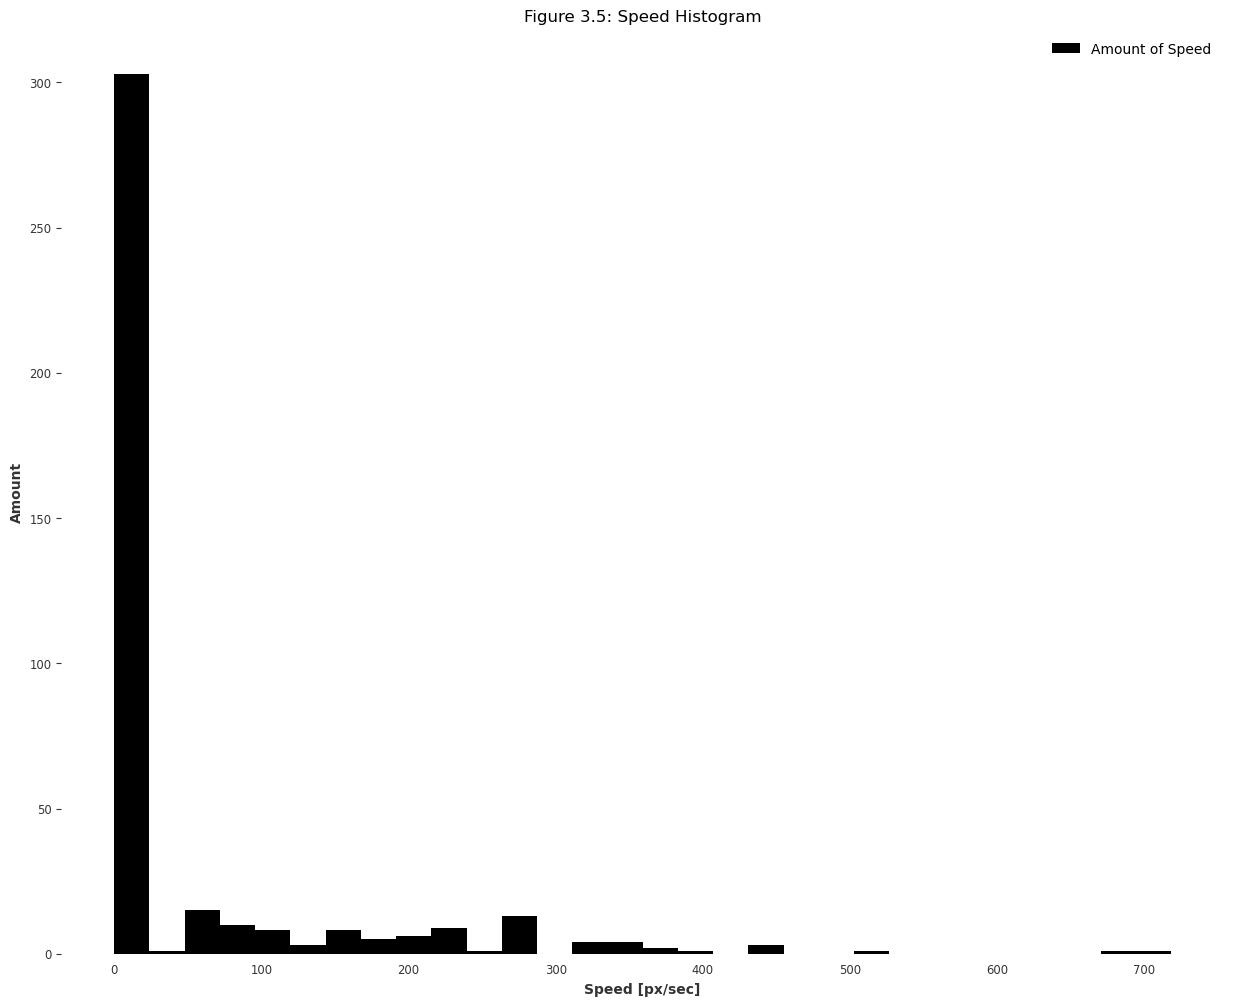

In [30]:
# Generate a line plot with two vectors 
# The columns 'Hstart' and 'Vstart' save the 2D coordinates of the moving object on a specific timeslot
fig, ax = plt.subplots(1, 1, figsize = (15, 12))
ax.hist(data['speed (px/sec)'], bins=30, label='Amount of Speed')
ax.grid()
ax.set_title('Figure 3.5: Speed Histogram')
ax.set(xlabel='Speed [px/sec]', ylabel='Amount')
ax.legend(loc='upper right')
#plt.show()

### Result: Histogram
The histogram plot shows a lot of null values, from the total 399 rows are around 300 with null speed!
A closer look on the dataset shows that most of the time the object is on the same place.
This come of the high sampling rate of the object detector.

In [31]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 399 entries, 1970-01-01 00:00:00.880000 to 1970-01-01 00:00:15.780000
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   X                      399 non-null    int64          
 1   Y                      399 non-null    int64          
 2   geometry               399 non-null    geometry       
 3   timestamp              399 non-null    object         
 4   traj_id                399 non-null    int64          
 5   direction              399 non-null    float64        
 6   timedelta              399 non-null    timedelta64[ns]
 7   distance (px)          399 non-null    float64        
 8   speed (px/sec)         399 non-null    float64        
 9   acceleration (px/sec)  399 non-null    float64        
dtypes: float64(4), geometry(1), int64(3), object(1), timedelta64[ns](1)
memory usage: 50.5+ KB


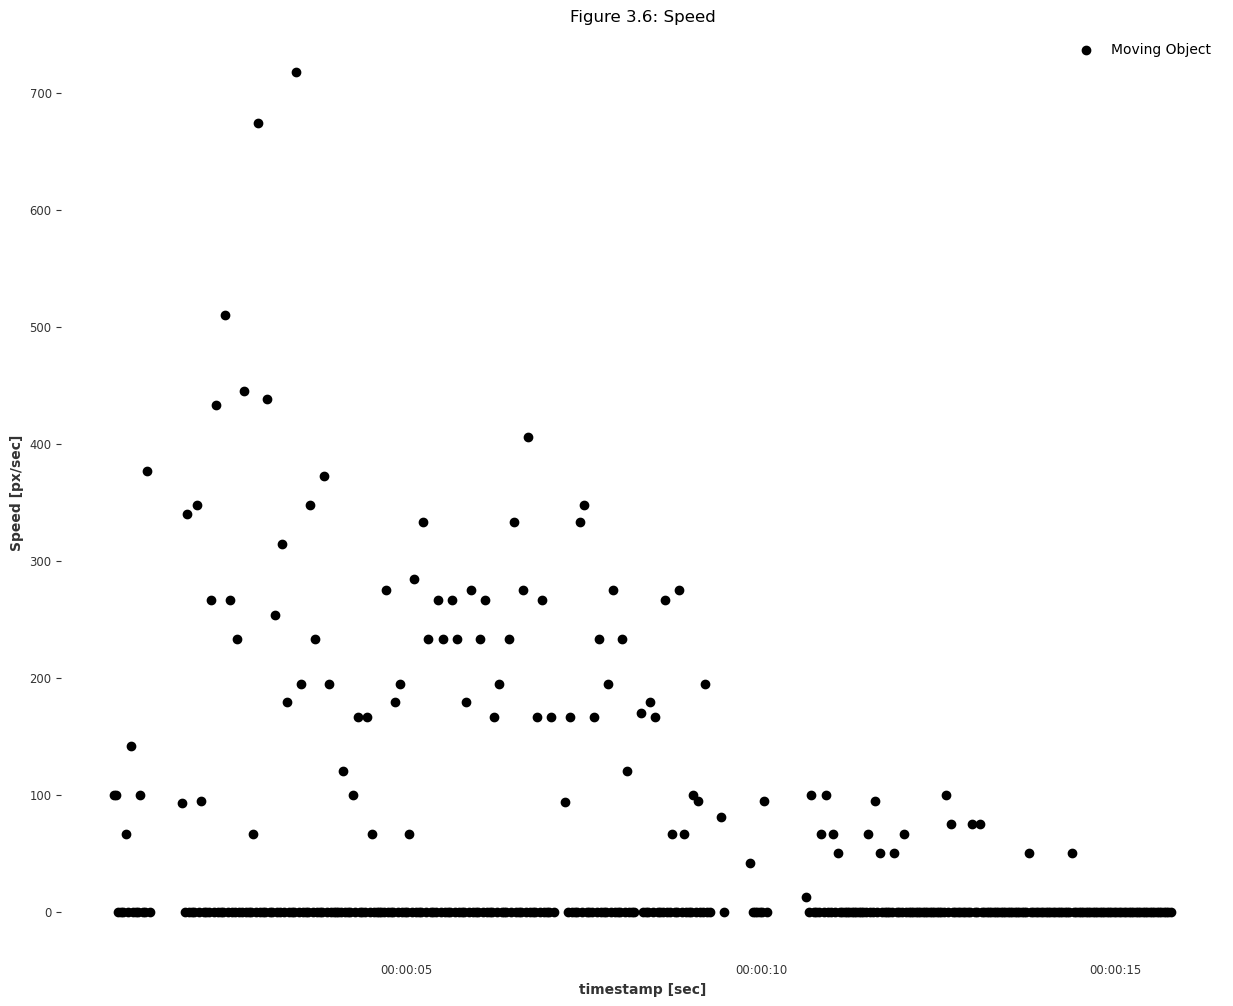

In [32]:
# Generate a line plot with two vectors 
# The columns 'Hstart' and 'Vstart' save the 2D coordinates of the moving object on a specific timeslot
fig, ax = plt.subplots(1, 1, figsize = (15, 12))
ax.scatter(data['timestamp'], data['speed (px/sec)'], label='Moving Object')
ax.grid()
ax.set_title('Figure 3.6: Speed')
ax.set(xlabel='timestamp [sec]', ylabel='Speed [px/sec]')
ax.legend(loc='upper right')
plt.show()

### Result: Scatter plot "timestamp"
The scatter plot shows no useful pattern.

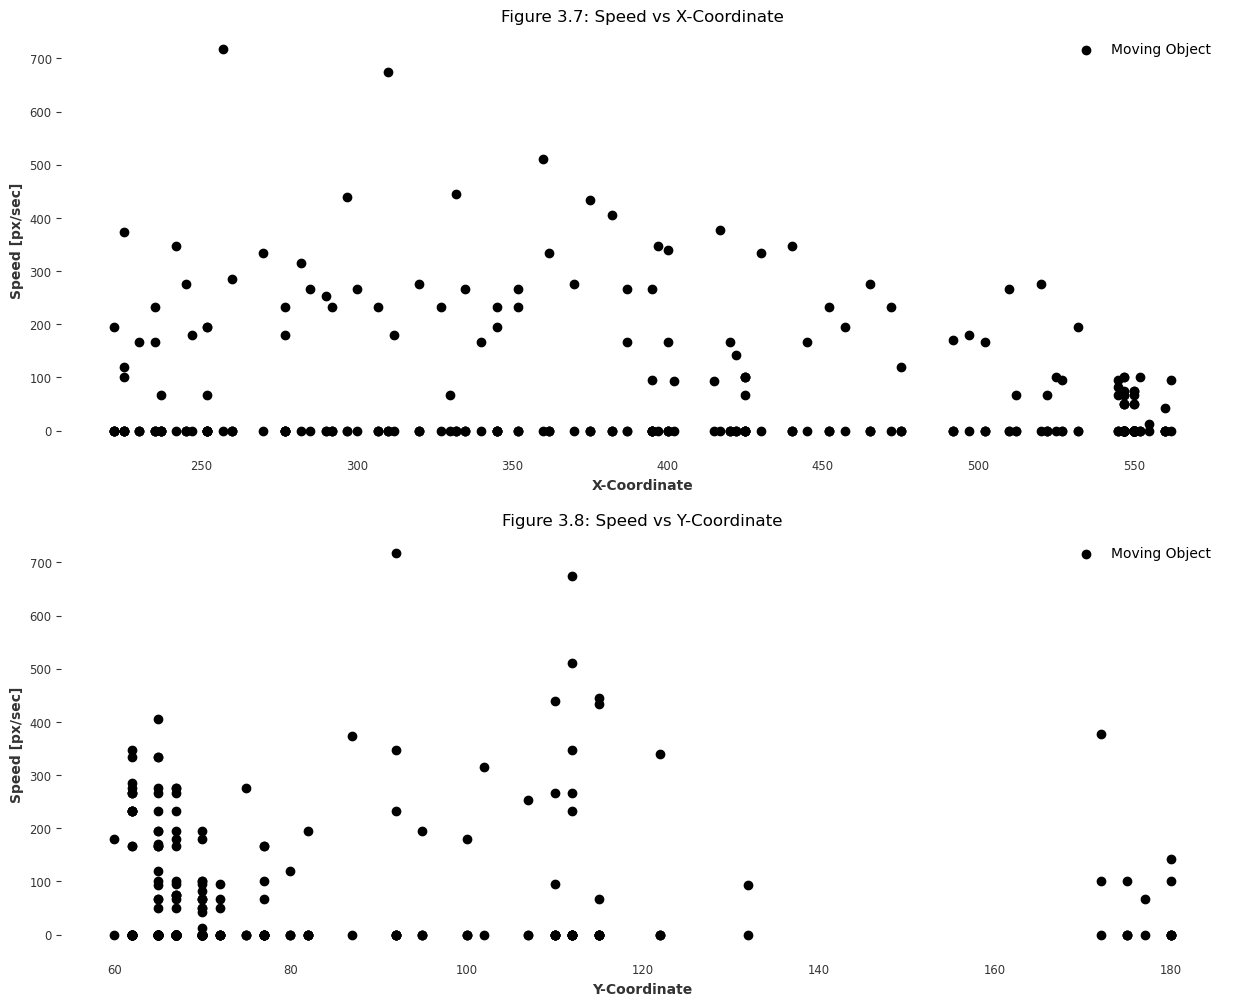

In [33]:
# Generate a line plot with two vectors 
# The columns 'Hstart' and 'Vstart' save the 2D coordinates of the moving object on a specific timeslot
fig, ax = plt.subplots(2, 1, figsize = (15, 12))
ax[0].scatter(data['X'], data['speed (px/sec)'], label='Moving Object')
ax[0].grid()
ax[0].set_title('Figure 3.7: Speed vs X-Coordinate')
ax[0].set(xlabel='X-Coordinate', ylabel='Speed [px/sec]')
ax[0].legend(loc='upper right')
ax[1].scatter(data['Y'], data['speed (px/sec)'], label='Moving Object')
ax[1].grid()
ax[1].set_title('Figure 3.8: Speed vs Y-Coordinate')
ax[1].set(xlabel='Y-Coordinate', ylabel='Speed [px/sec]')
ax[1].legend(loc='upper right')

plt.show()


### Result: Scatter plot "Coordinates"
The scatter plot shows no useful pattern.

### Plot: Autocorrelations
For time series it is mandatory to try autocorrelation plots.

### Plot: Autocorrelation "X-Coordinates"

Text(0.5, 1.0, 'Differenced Partial Autocorrelation X')

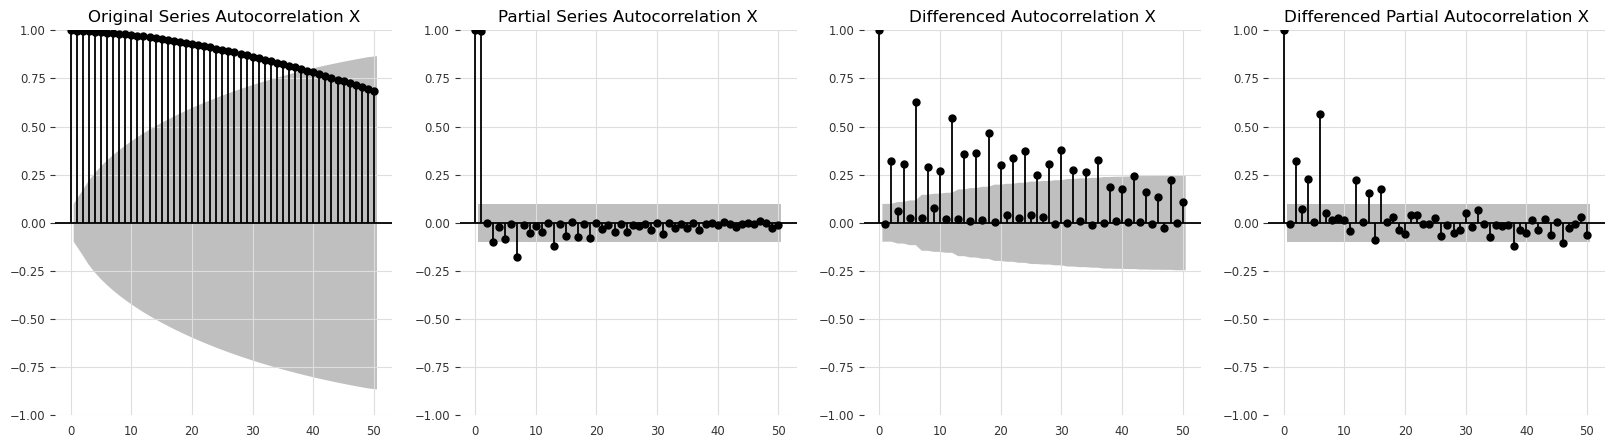

In [34]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
plot_acf(data['X'], ax = ax[0], lags=50);
ax[0].set_title('Original Series Autocorrelation X')
plot_pacf(data['X'].dropna(), ax = ax[1], method = 'ywm', lags=50);
ax[1].set_title('Partial Series Autocorrelation X')
plot_acf(data['X'].diff().dropna(), ax = ax[2], lags=50);
ax[2].set_title('Differenced Autocorrelation X')
plot_pacf(data['X'].diff().dropna(), ax = ax[3], method = 'ywm', lags=50);
ax[3].set_title('Differenced Partial Autocorrelation X')

### Result: Autocorrelation plots "X-Coordinates"
The acf plot on the original series shows a lot of correlation up to 40 lags. This is not helpful for further use in modeling.
The pacf plot on the orignal series shows nice results. Only two or three lags bring valueable results.
The acf on the differenced series of data shows better results than the acf on the original data series, but still not good for modeling. The pacf on the differneced series data shows good results.

### Plot: Autocorrelation "Y-Coordinates"

Text(0.5, 1.0, 'Differenced Partial Autocorrelation Y')

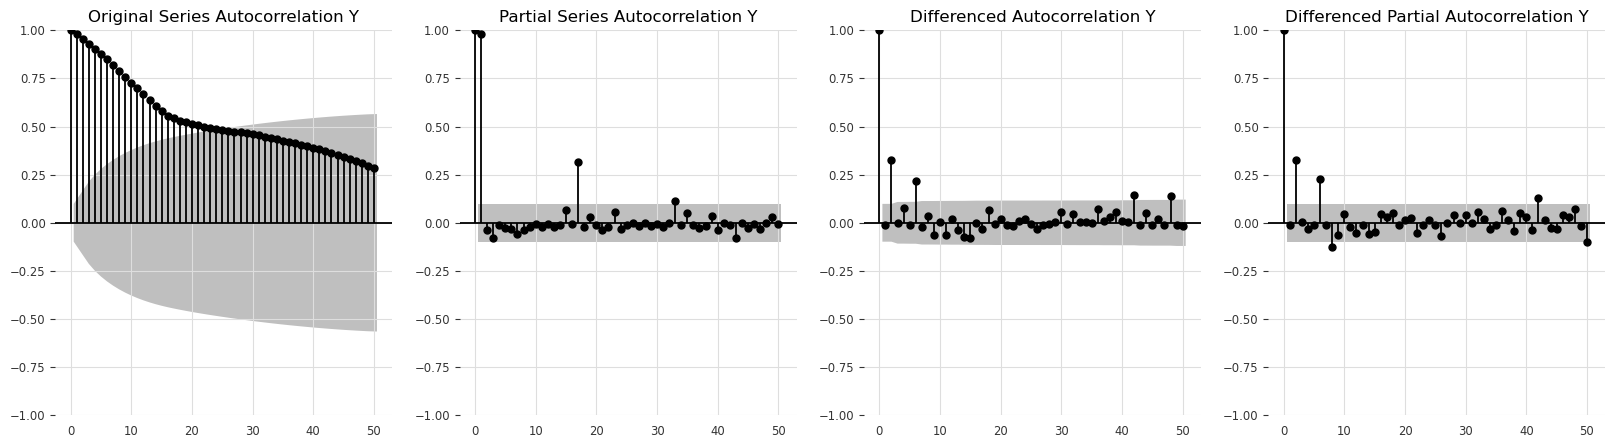

In [35]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
plot_acf(data['Y'], ax = ax[0], lags=50);
ax[0].set_title('Original Series Autocorrelation Y')
plot_pacf(data['Y'].dropna(), ax = ax[1], method = 'ywm', lags=50);
ax[1].set_title('Partial Series Autocorrelation Y')
plot_acf(data['Y'].diff().dropna(), ax = ax[2], lags=50);
ax[2].set_title('Differenced Autocorrelation Y')
plot_pacf(data['Y'].diff().dropna(), ax = ax[3], method = 'ywm', lags=50);
ax[3].set_title('Differenced Partial Autocorrelation Y')

### Result: Autocorrelation plots "Y-Coordinates"
The acf plot on the original series shows a lot of correlation up to 30 lags. This is not helpful for further use in modeling.
The pacf plot on the orignal series shows nice results. There are only two or three lags valueable lags.
The acf and pacf plot on the differned series of data brings the best results.

### Plot: Autocorrelation "speed"

Text(0.5, 1.0, 'Differenced Partial Autocorrelation [speed]')

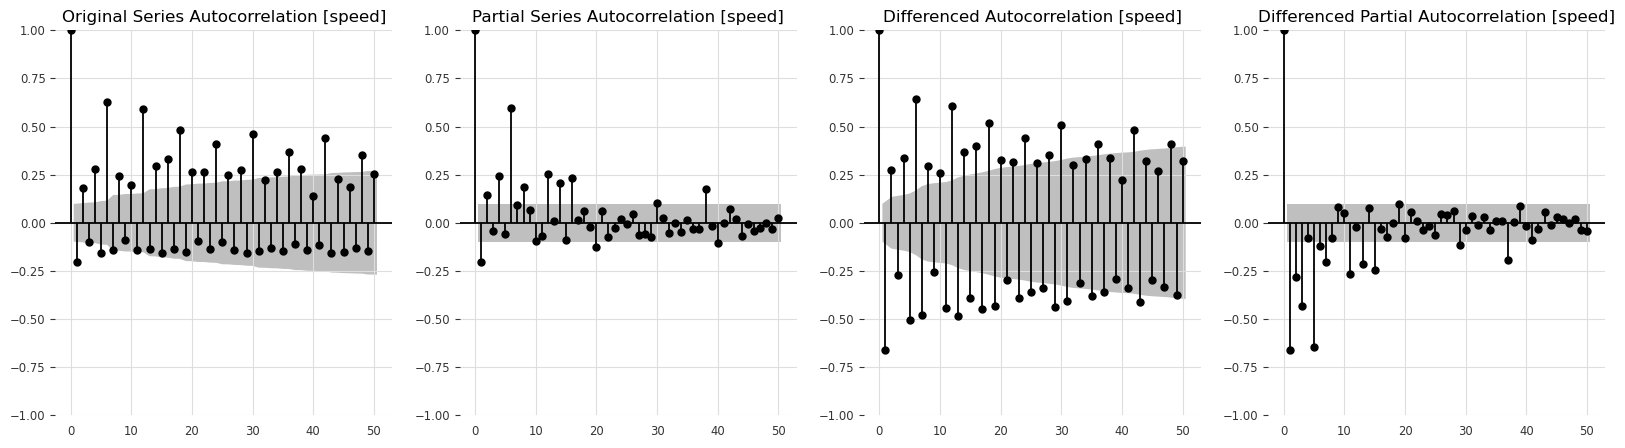

In [36]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
plot_acf(data['speed (px/sec)'], ax = ax[0], lags=50);
ax[0].set_title('Original Series Autocorrelation [speed]')
plot_pacf(data['speed (px/sec)'].dropna(), ax = ax[1], method = 'ywm', lags=50);
ax[1].set_title('Partial Series Autocorrelation [speed]')
plot_acf(data['speed (px/sec)'].diff().dropna(), ax = ax[2], lags=50);
ax[2].set_title('Differenced Autocorrelation [speed]')
plot_pacf(data['speed (px/sec)'].diff().dropna(), ax = ax[3], method = 'ywm', lags=50);
ax[3].set_title('Differenced Partial Autocorrelation [speed]')

### Result: Autocorrelation plots "speed"
The acf plot on the original series shows a lot of correlation up to 50 lags. This is not helpful for further use in modeling.
The pacf plot on the orignal series shows better results. There are around 10 valueable lags under the first 20 lags.
The acf on the differenced series are similar bad as on the original series data.
The pacf on the differenced data is similar good as on the original series data. 

### Plot: Correlation
A must have for a good analyzing the date is a correlation matrix.

<Axes: title={'center': 'Figure 3.9: Headmap'}>

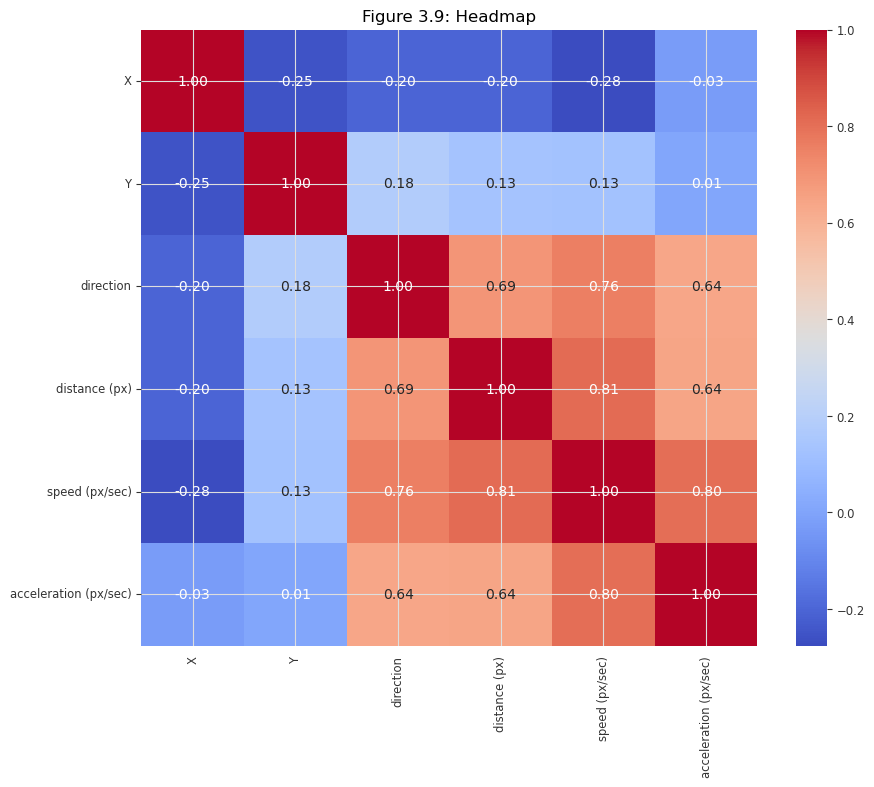

In [37]:
# Correlation matrix and heatmap
df = data[['X','Y','direction','distance (px)','speed (px/sec)','acceleration (px/sec)']]
correlation = df.corr()
plt.figure(figsize=(10, 8))
plt.title('Figure 3.9: Headmap')
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f", square=True)

# 4.) Modeling
From the data understandig the current data are a time series dataset. Therefore it is mandatory to use time series models like: <br>
- ARIMA or SARIMA
- LSTM long short time memory network

A dictionary for evaluating the results will be used and 
for the evaluating of the results two scores are used: MSE and MAPE.

In [162]:
# Create a dictionary for evaluating the results
results_df = ''
models     = ['ARIMA', 'LSTM']

result_dict = {'model': ['ARIMA', 'LSTM'],
               'train MSE'       : [0, 0],
               'test MSE'        : [0, 0],
               'train MAPE'      : [0, 0],       
               'test MAPE'       : [0, 0],  
               'average fit time': [0, 0],
               'forecast_ratio'  : [0, 0]}

results_df = pd.DataFrame(result_dict).set_index('model')

In [163]:
# show the current dataset for the modeling
data.head()

,X,Y,geometry,timestamp,traj_id,direction,timedelta,distance (px),speed (px/sec),acceleration (px/sec)
timestamp,,,,,,,,,,
1970-01-01 00:00:00.880,425,172,POINT (425.000 172.000),1970-01-01 00:00:00.880000,1,0.0,0 days 00:00:00.040000,0.0,100.0,0.000000
1970-01-01 00:00:00.910,425,175,POINT (425.000 175.000),1970-01-01 00:00:00.910000,1,0.0,0 days 00:00:00.030000,3.0,100.0,0.000000
1970-01-01 00:00:00.940,425,175,POINT (425.000 175.000),1970-01-01 00:00:00.940000,1,0.0,0 days 00:00:00.030000,0.0,0.0,-7456.454307
1970-01-01 00:00:00.980,425,175,POINT (425.000 175.000),1970-01-01 00:00:00.980000,1,0.0,0 days 00:00:00.040000,0.0,0.0,0.000000
1970-01-01 00:00:01.010,425,175,POINT (425.000 175.000),1970-01-01 00:00:01.010000,1,0.0,0 days 00:00:00.030000,0.0,0.0,0.000000


In [164]:
data.describe()

,X,Y,traj_id,direction,timedelta,distance (px),speed (px/sec),acceleration (px/sec)
count,399.000000,399.000000,399.0,399.000000,399,399.000000,399.000000,399.000000
mean,437.245614,78.185464,1.0,34.450718,0 days 00:00:00.037443609,1.698881,48.527931,318.205338
std,118.426131,25.484170,0.0,74.061838,0 days 00:00:00.038981779,4.068635,107.586457,11670.821852
min,222.000000,60.000000,1.0,0.000000,0 days 00:00:00.030000,0.000000,0.000000,-50265.818659
25%,332.000000,65.000000,1.0,0.000000,0 days 00:00:00.030000,0.000000,0.000000,0.000000
50%,472.000000,67.000000,1.0,0.000000,0 days 00:00:00.030000,0.000000,0.000000,0.000000
75%,550.000000,77.000000,1.0,0.000000,0 days 00:00:00.040000,0.000000,0.000000,0.000000
max,562.000000,180.000000,1.0,315.000000,0 days 00:00:00.560000,42.720019,718.021974,53538.980426


### 4.1 Create Train and Test dataset
Therefore we split the data in 75% for training and 25% for testing. There are two variables (X and Y) for the forcast so we
have to do that for both of them.

In [165]:
# First of all we generate our train and test datasets for X coordinates as series
X_train, X_test = data.iloc[:-99]['X'].values, data.iloc[-99:]['X'].values

In [166]:
# First of all we generate our train and test datasets for X coordinates as dataframe
X_train_df, X_test_df = data.iloc[:-99]['X'], data.iloc[-99:]['X']

In [167]:
# First of all we generate our train and test datasets for Y coordinates as series
Y_train, Y_test = data.iloc[:-99]['Y'].values, data.iloc[-99:]['Y'].values

In [168]:
# First of all we generate our train and test datasets for Y coordinates as dataframe
Y_train_df, Y_test_df = data.iloc[:-99]['Y'], data.iloc[-99:]['Y']

### Assumptions of Linearity
Next, we want to check the assumptions of our model before building it.  Specifically, this was the notion that our time series is stationary for the ARMA models.  With the `adfuller` test we determine if the series is stationary. If the $p$ value `pval` is below of a threshold at $p = 0.05$ the dataset is stationary.

In [169]:
pval = adfuller(X_train_df)[1]
print(f'The p-value of <original series X> is:     {pval: .4f}')

The p-value of <original series X> is:      0.3295


In [170]:
pval = adfuller(X_train_df.diff().dropna())[1]
print(f'The p-value of <original series X> is:     {pval: .4f}')

The p-value of <original series X> is:      0.5176


In [171]:
# lets try second order differnencing
pval = adfuller(X_train_df.diff().dropna().diff().dropna())[1]
print(f'The p-value of <original series X> is:     {pval: .4f}')

The p-value of <original series X> is:      0.0000


In [172]:
pval = adfuller(Y_train)[1]
print(f'The p-value of <original series Y> is:     {pval: .4f}')

The p-value of <original series Y> is:      0.0000


In [173]:
pval = adfuller(Y_train_df.diff().dropna())[1]
print(f'The p-value of <differenced series Y> is:  {pval: .4f}')

The p-value of <differenced series Y> is:   0.0000


### Findings
The adfuller test shows a stationary for X_train with 2 times differnencing.
Lets try are ARIMA model to see the outcome.

### 4.2 Model: ARIMA for X-Coordinate 

In [174]:
arima = ARIMA(X_train, order = (2, 1, 2)).fit()
forcast   = arima.forecast(len(X_test))
preds     = arima.predict()
mse_train = mean_squared_error(preds, X_train)
mse_test  = mean_squared_error(forcast, X_test)
# print the last 5 predictions
print(preds[:5])
print('Train mean squart error: %2.3f' %mse_train)
print('Test  mean squart error:   %2.3f' %mse_test)
#print(arma.summary())

[  0.         425.00022893 425.00265045 425.00008655 425.00161348]
Train mean squart error: 614.316
Test  mean squart error:   7.548


In [175]:
print(X_test[:5])

[547 547 547 547 547]


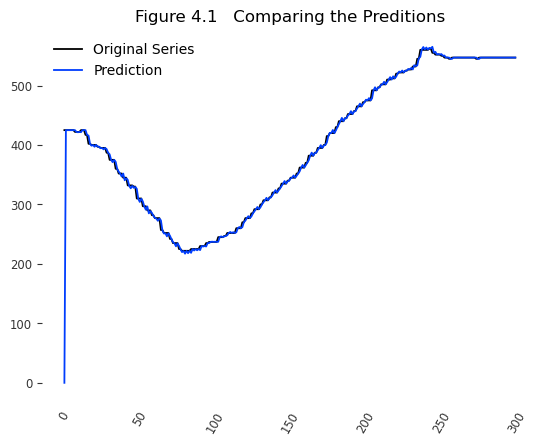

In [176]:
plt.plot(X_train, label = 'Original Series')
plt.plot(arima.predict(), label = 'Prediction')
plt.title('Figure 4.1   Comparing the Preditions')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();

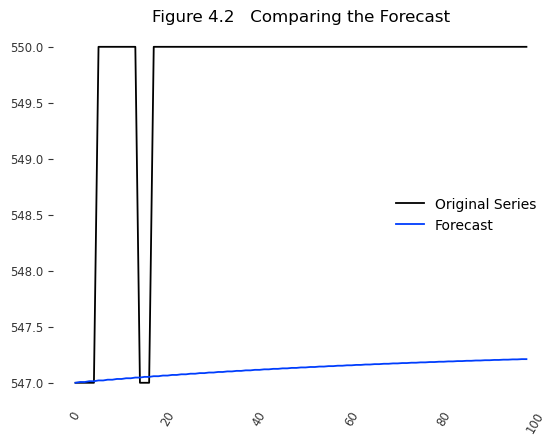

In [177]:
plt.plot(X_test, label = 'Original Series')
plt.plot(arima.forecast(steps = len(X_test)), label = 'Forecast')
plt.title('Figure 4.2   Comparing the Forecast')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();

### 4.2.1 Hyperparameter Tuning: X-Coordinate Model

In [178]:
# set the search parameter for the grid search
Xres_dict = {'order'          : [(1, 0, 1), (10, 1, 10), (20, 1, 20), (30, 1, 30), (40, 1, 40), (45, 1, 45), (50, 1, 50)],
            'order_str'       : ['1,0,1', '10,1,10', '20,1,20', '30,1,30', '40,1,40', '45,1,45', '50,1,50'], 
            'train score MSE' : [0, 0, 0, 0, 0, 0, 0],
            'test score MSE'  : [0, 0, 0, 0, 0, 0, 0],
            'train score MAPE': [0, 0, 0, 0, 0, 0, 0],
            'test score MAPE' : [0, 0, 0, 0, 0, 0, 0],
            'fit time'        : [0, 0, 0, 0, 0, 0, 0]}

In [179]:
# lets try a grid search with the differnet parameters
for i in range (len(Xres_dict['order'])):
    start_time  = time.time()
    arima       = ARIMA(X_train, order = Xres_dict['order'][i]).fit()
    Xres_dict['fit time'][i] = time.time() - start_time
    forcast     = arima.forecast(len(X_test))
    preds       = arima.predict()
    Xres_dict['train score MSE'][i]  = mean_squared_error(preds, X_train)
    Xres_dict['test score MSE'][i]   = mean_squared_error(forcast, X_test)
    Xres_dict['train score MAPE'][i] = mean_absolute_percentage_error(X_train, preds)
    Xres_dict['test score MAPE'][i]  = mean_absolute_percentage_error(X_test, forcast)
    print('Train MSE  : %02.3f' %Xres_dict['train score MSE'][i])
    print('Test  MSE  :  %02.3f' %Xres_dict['test score MSE'][i])
    print('Train MAPE :   %02.3f' %Xres_dict['train score MAPE'][i])
    print('Test  MAPE :   %02.3f' %Xres_dict['test score MAPE'][i])
    print('Fit time   :   %02.3f sec' %Xres_dict['fit time'][i])
    print()

Train MSE  : 25.788
Test  MSE  :  56.237
Train MAPE :   0.006
Test  MAPE :   0.013
Fit time   :   0.173 sec

Train MSE  : 611.263
Test  MSE  :  15.091
Train MAPE :   0.008
Test  MAPE :   0.007
Fit time   :   1.143 sec

Train MSE  : 610.486
Test  MSE  :  68.560
Train MAPE :   0.008
Test  MAPE :   0.013
Fit time   :   4.465 sec

Train MSE  : 610.131
Test  MSE  :  185.832
Train MAPE :   0.008
Test  MAPE :   0.024
Fit time   :   10.074 sec

Train MSE  : 609.832
Test  MSE  :  161.849
Train MAPE :   0.008
Test  MAPE :   0.020
Fit time   :   31.607 sec

Train MSE  : 609.728
Test  MSE  :  43.836
Train MAPE :   0.008
Test  MAPE :   0.010
Fit time   :   42.416 sec

Train MSE  : 609.527
Test  MSE  :  21.711
Train MAPE :   0.008
Test  MAPE :   0.007
Fit time   :   52.881 sec



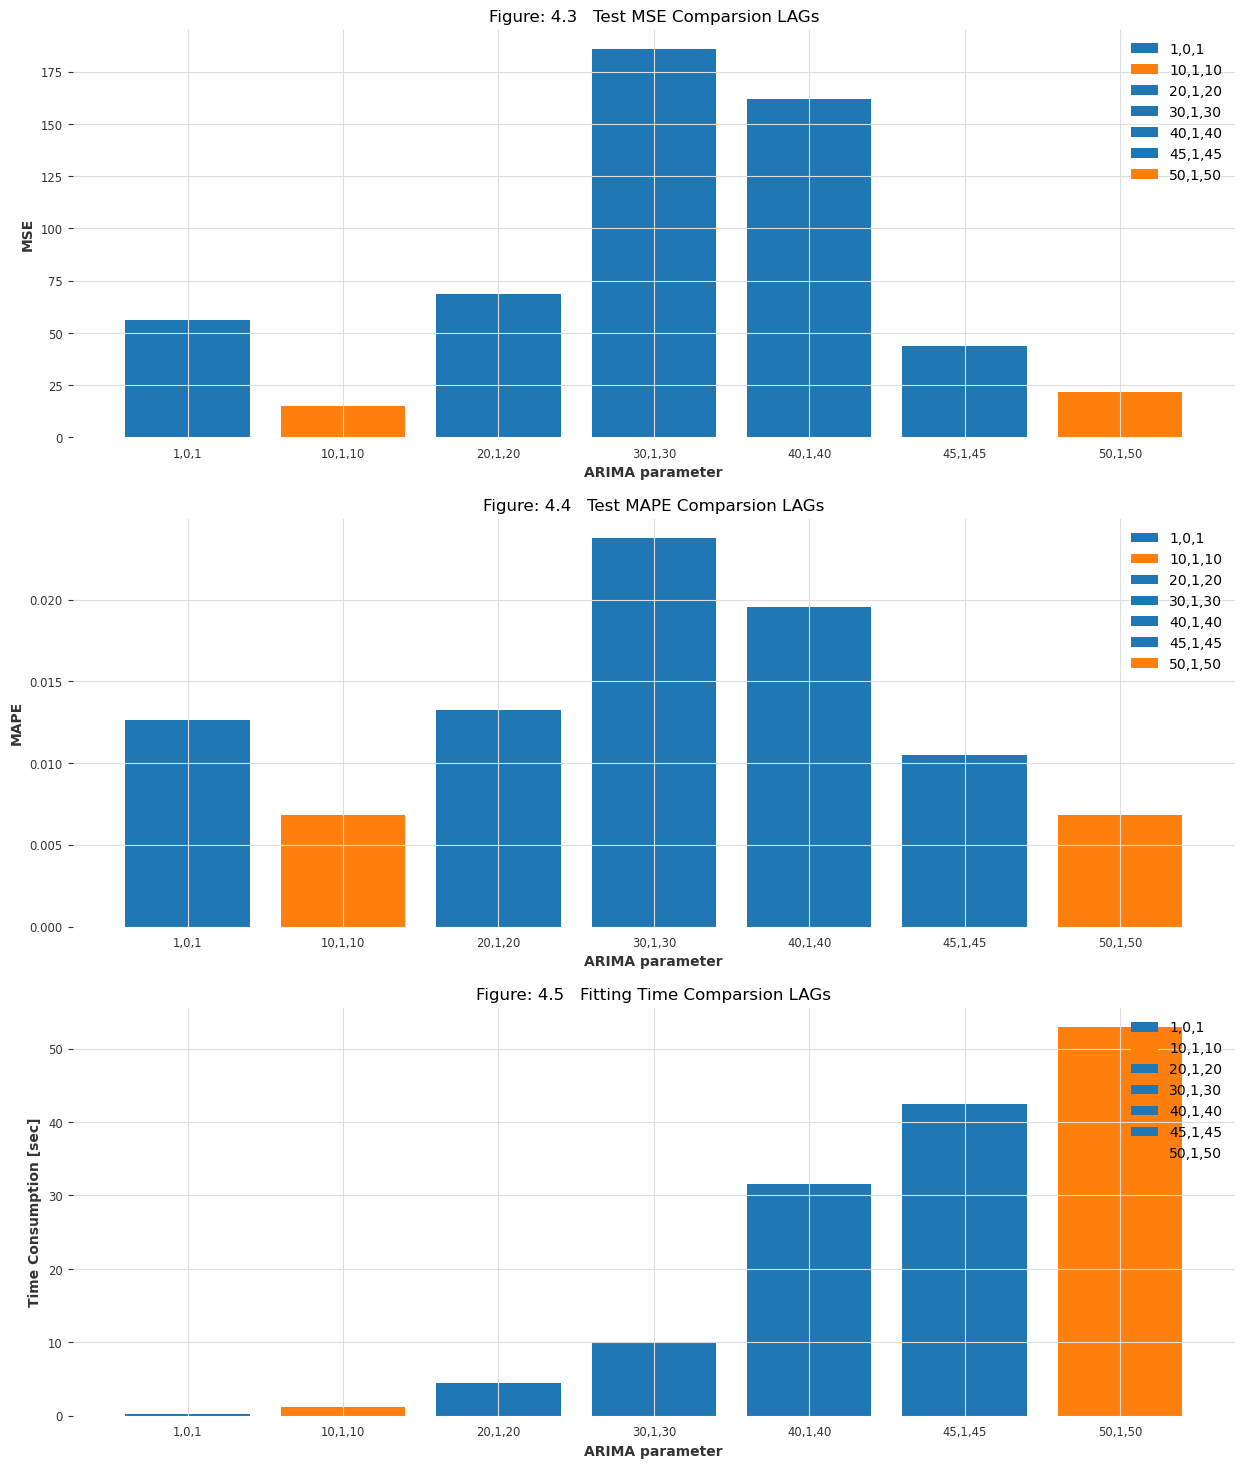

In [180]:
# Lets plot the fit time to see the model performance with the differnent hyperparameters
bar_colors = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:orange']
fig, ax = plt.subplots(3, 1, figsize = (15, 18))
ax[0].bar(Xres_dict['order_str'], Xres_dict['test score MSE'], label=Xres_dict['order_str'], color=bar_colors)
ax[0].set_title('Figure: 4.3   Test MSE Comparsion LAGs')
ax[0].set(xlabel='ARIMA parameter', ylabel='MSE')
ax[0].legend(loc='upper right')
ax[1].bar(Xres_dict['order_str'], Xres_dict['test score MAPE'], label=Xres_dict['order_str'], color=bar_colors)
ax[1].set_title('Figure: 4.4   Test MAPE Comparsion LAGs')
ax[1].set(xlabel='ARIMA parameter', ylabel='MAPE')
ax[1].legend(loc='upper right')
ax[2].bar(Xres_dict['order_str'], Xres_dict['fit time'], label=Xres_dict['order_str'], color=bar_colors)
ax[2].set_title('Figure: 4.5   Fitting Time Comparsion LAGs')
ax[2].set(xlabel='ARIMA parameter', ylabel='Time Consumption [sec]')
ax[2].legend(loc='upper right')

plt.show()

### Findings
The last plots shows the test errors MSE and MAPE compared to the differnet ARIMA parameters.<br>
The main findings are:
1. The plot in figure 4.3 and 4.4 shows the growing and falling of the MSE and MAPE with the order of used lags
2. The plot in figure 4.5 shows the exponential grow of the fitting time of the ARIMA model with growing the lags
3. More lags brings more information from the past in the forecast, and should be considered for the final application
4. There are two possibilities: less `lags (10,1,10)` with much faster fitting time or larger `lags (50,1,50)` with maybe better forecast

## 4.2.2 Result: Hyperparamter Tuning
The best score comes with the parameter `order(50,1,50)`

In [181]:
# lets plot the found values
start_time = time.time()
arima      = ARIMA(X_train, order = (50, 1, 50)).fit()
fit_time   = time.time() - start_time
forcast    = arima.forecast(len(X_test))
preds      = arima.predict()
mse_train  = mean_squared_error(preds, X_train)
mae_train  = mean_absolute_percentage_error(X_train, preds)
mse_test   = mean_squared_error(forcast, X_test)
mae_test   = mean_absolute_percentage_error(X_test, forcast)
# print the last 5 predictions
print(preds[:5])
print('Train mean squart error             : %2.3f' %mse_train)
print('Train mean absolute percentage error:   %2.3f' %mae_train)
print('Test  mean squart error             :   %2.3f' %mse_test)
print('Test  mean absolute percentage error:   %2.3f' %mae_test)
print('Fit time                            :   %2.3f sec' %fit_time)
#print(arima.summary())

[  0.         425.00004744 425.0018875  425.00052615 425.00124975]
Train mean squart error             : 609.527
Train mean absolute percentage error:   0.008
Test  mean squart error             :   21.711
Test  mean absolute percentage error:   0.007
Fit time                            :   53.439 sec


In [182]:
# lets build a series fo x-coordinates to use for plotting the forcast on the right place
x_test_offset=[]
for i in range (300, 399):
    x_test_offset.append(i)
print(x_test_offset)
print(type(x_test_offset))

[300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398]
<class 'list'>


In [183]:
X_arima_forcast = arima.forecast(steps = len(X_test))

Text(0, 0.5, 'Y-Coordinate [px]')

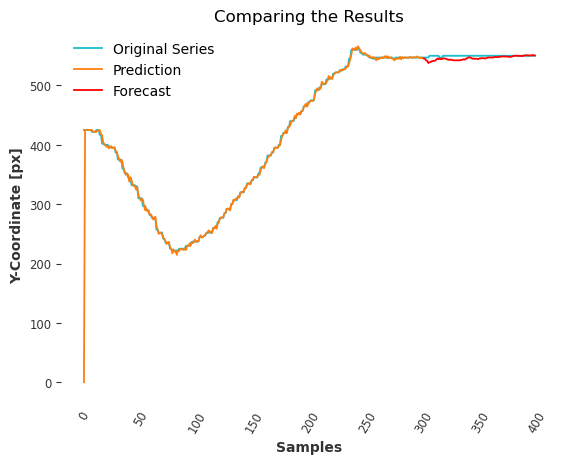

In [184]:
plt.plot(np.concatenate((X_train, X_test)), label = 'Original Series', color='tab:cyan')
plt.plot(arima.predict(), label = 'Prediction', color='tab:orange')
plt.plot(x_test_offset, X_arima_forcast, color='r', label = 'Forecast')
plt.title('Comparing the Results')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();
plt.xlabel('Samples')
plt.ylabel('Y-Coordinate [px]')

### 4.2.3 Model: ARIMA for X-Coordinate Save the Results

In [185]:
# Set results of the model in the result dictenary
result_dict['train MSE'][0]  = mse_train
result_dict['test MSE'][0]   = mse_test
result_dict['train MAPE'][0] = mae_train
result_dict['test MAPE'][0]  = mae_test
result_dict['average fit time'][0]  = fit_time

## 4.3 Model: ARIMA for Y-Coordinate 

In [186]:
arima = ARIMA(Y_train, order = (10, 1, 10)).fit()
forcast   = arima.forecast(len(Y_test))
preds     = arima.predict()
mse_train = mean_squared_error(preds, Y_train)
mse_test  = mean_squared_error(forcast, Y_test)
# print the last 5 predictions
print(preds[:5])
print('Train mean squart error:  %2.3f' %mse_train)
print('Test  mean squart error:   %2.3f' %mse_test)
#print(arma.summary())

[  0.         172.0000104  175.02429409 175.96724896 174.90950344]
Train mean squart error:  104.917
Test  mean squart error:   17.434


In [187]:
print(Y_test[:5])

[70 70 70 67 67]


Text(0, 0.5, 'Y-Coordinate [px]')

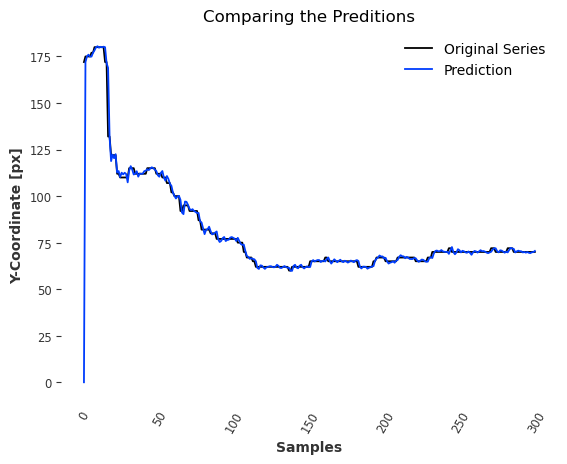

In [188]:
plt.plot(Y_train, label = 'Original Series')
plt.plot(arima.predict(), label = 'Prediction')
plt.title('Comparing the Preditions')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();
plt.xlabel('Samples')
plt.ylabel('Y-Coordinate [px]')

Text(0, 0.5, 'Y-Coordinate [px]')

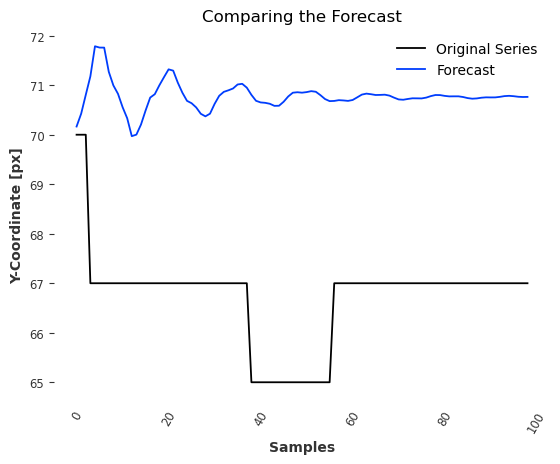

In [189]:
plt.plot(Y_test, label = 'Original Series')
plt.plot(arima.forecast(steps = len(Y_test)), label = 'Forecast')
plt.title('Comparing the Forecast')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();
plt.xlabel('Samples')
plt.ylabel('Y-Coordinate [px]')

### 4.3.1 Hyperparameter Tuning: Y-Coordinate Model
lets do the same as for X-coordinate model

In [190]:
# set the search parameter for the grid search
Yres_dict = {'order'          : [(1, 0, 1), (10, 1, 10), (20, 1, 20), (30, 1, 30), (40, 1, 40), (45, 1, 45), (50, 1, 50)],
            'order_str'       : ['1,0,1', '10,1,10', '20,1,20', '30,1,30', '40,1,40', '45,1,45', '50,1,50'], 
            'train score MSE' : [0, 0, 0, 0, 0, 0, 0],
            'test score MSE'  : [0, 0, 0, 0, 0, 0, 0],
            'train score MAPE': [0, 0, 0, 0, 0, 0, 0],
            'test score MAPE' : [0, 0, 0, 0, 0, 0, 0],
            'fit time'        : [0, 0, 0, 0, 0, 0, 0]}

In [191]:
# lets try a grid search with the differnet parameters
for i in range (len(Yres_dict['order'])):
    start_time  = time.time()
    arima       = ARIMA(Y_train, order = Yres_dict['order'][i]).fit()
    Yres_dict['fit time'][i] = time.time() - start_time
    forcast     = arima.forecast(len(Y_test))
    preds       = arima.predict()
    Yres_dict['train score MSE'][i]  = mean_squared_error(preds, Y_train)
    Yres_dict['test score MSE'][i]   = mean_squared_error(forcast, Y_test)
    Yres_dict['train score MAPE'][i] = mean_absolute_percentage_error(Y_train, preds)
    Yres_dict['test score MAPE'][i]  = mean_absolute_percentage_error(Y_test, forcast)
    print('Train MSE  : %02.3f' %Yres_dict['train score MSE'][i])
    print('Test  MSE  :  %02.3f' %Yres_dict['test score MSE'][i])
    print('Train MAPE :   %02.3f' %Yres_dict['train score MAPE'][i])
    print('Test  MAPE :   %02.3f' %Yres_dict['test score MAPE'][i])
    print('Fit time   :   %02.3f sec' %Yres_dict['fit time'][i])
    print()

Train MSE  : 19.063
Test  MSE  :  48.047
Train MAPE :   0.009
Test  MAPE :   0.099
Fit time   :   0.137 sec

Train MSE  : 104.917
Test  MSE  :  17.434
Train MAPE :   0.015
Test  MAPE :   0.061
Fit time   :   1.345 sec

Train MSE  : 105.486
Test  MSE  :  11.798
Train MAPE :   0.016
Test  MAPE :   0.050
Fit time   :   4.441 sec

Train MSE  : 105.120
Test  MSE  :  14.883
Train MAPE :   0.016
Test  MAPE :   0.056
Fit time   :   9.617 sec

Train MSE  : 105.482
Test  MSE  :  3.347
Train MAPE :   0.017
Test  MAPE :   0.023
Fit time   :   30.341 sec

Train MSE  : 105.429
Test  MSE  :  12.549
Train MAPE :   0.017
Test  MAPE :   0.051
Fit time   :   40.956 sec

Train MSE  : 105.542
Test  MSE  :  3.011
Train MAPE :   0.017
Test  MAPE :   0.022
Fit time   :   54.995 sec



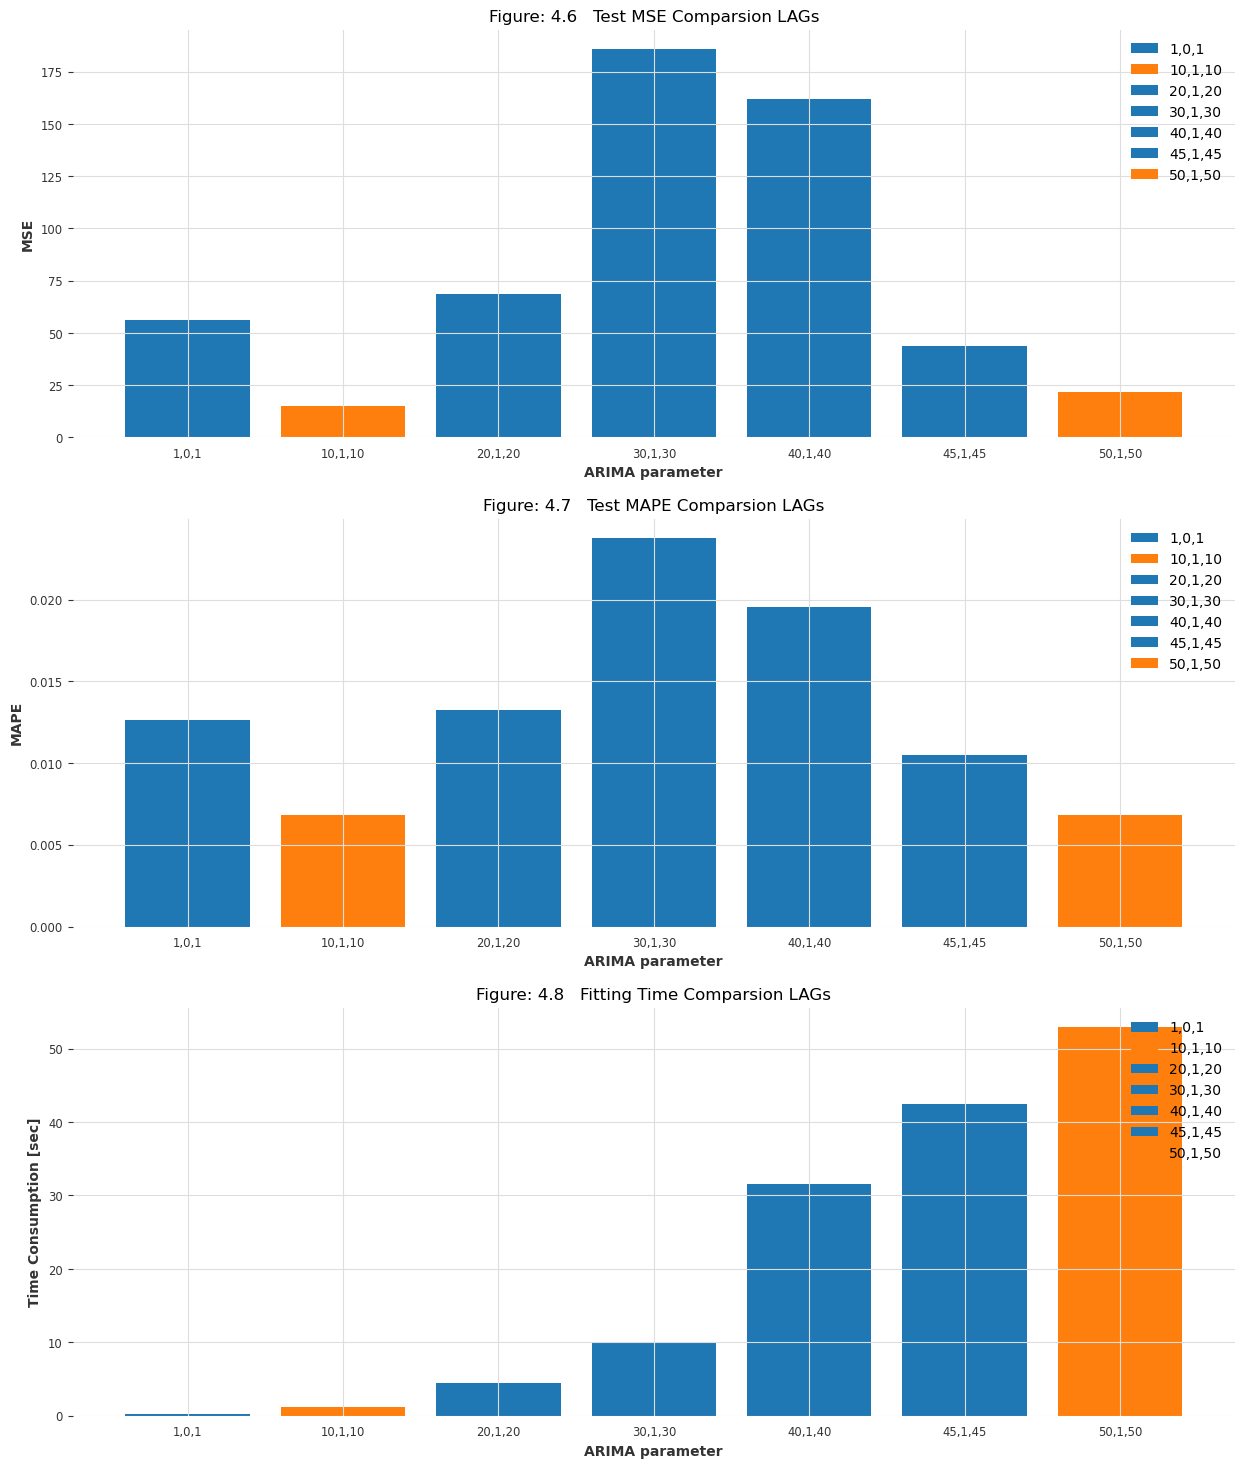

In [192]:
# Lets plot the fit time to see the model performance with the differnent hyperparameters
bar_colors = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:orange']
fig, ax = plt.subplots(3, 1, figsize = (15, 18))
ax[0].bar(Xres_dict['order_str'], Xres_dict['test score MSE'], label=Xres_dict['order_str'], color=bar_colors)
ax[0].set_title('Figure: 4.6   Test MSE Comparsion LAGs')
ax[0].set(xlabel='ARIMA parameter', ylabel='MSE')
ax[0].legend(loc='upper right')
ax[1].bar(Xres_dict['order_str'], Xres_dict['test score MAPE'], label=Xres_dict['order_str'], color=bar_colors)
ax[1].set_title('Figure: 4.7   Test MAPE Comparsion LAGs')
ax[1].set(xlabel='ARIMA parameter', ylabel='MAPE')
ax[1].legend(loc='upper right')
ax[2].bar(Xres_dict['order_str'], Xres_dict['fit time'], label=Xres_dict['order_str'], color=bar_colors)
ax[2].set_title('Figure: 4.8   Fitting Time Comparsion LAGs')
ax[2].set(xlabel='ARIMA parameter', ylabel='Time Consumption [sec]')
ax[2].legend(loc='upper right')

plt.show()

### 4.3.2 Findings
The last plots shows the test errors MSE and MAPE compared to the differnet ARIMA parameters.<br>
The main findings are:
1. The plot in figure 3.6 and 3.7 shows the growing and falling of the MSE and MAPE with the order of used lags
2. The plot in figure 3.8 shows the exponential grow of the fitting time of the ARIMA model with growing the lags
3. More lags brings more information from the past in the forecast, and should be considered for the final application
4. There are two possibilities: less `lags (10,1,10)` with much faster fitting time or larger `lags (50,1,50)` with maybe better forecast

### 4.3.3 Result: Hyperparameter Tuning
The best score comes with the parameter `order(50,1,50)` in case the application has enough computing power for calculating the 50 lags. An alternative is also the parameter `order(10,1,10)`, because the fitting time is more than 10 times lower, but the forecast is maybe not so good.

## 4.4 Generate Model "ARIMA"

In [193]:
# lets plot the found values
start_time = time.time()
arima = ARIMA(Y_train, order = (50, 1, 50)).fit()
fit_time  = time.time() - start_time
forcast   = arima.forecast(len(Y_test))
preds     = arima.predict()
mse_train = mean_squared_error(preds, Y_train)
mae_train = mean_absolute_percentage_error(Y_train, preds)
mse_test  = mean_squared_error(forcast, Y_test)
mae_test  = mean_absolute_percentage_error(Y_test, forcast)
# print the last 5 predictions
print(preds[:5])
print('Train mean squart error             : %2.3f' %mse_train)
print('Train mean absolute percentage error:   %2.3f' %mae_train)
print('Test  mean squart error             :  %2.3f' %mse_test)
print('Test  mean absolute percentage error:   %2.3f' %mae_test)
#print(arma.summary())

[  0.         172.00005897 175.08703034 175.94889604 174.85041961]
Train mean squart error             : 105.542
Train mean absolute percentage error:   0.017
Test  mean squart error             :  3.011
Test  mean absolute percentage error:   0.022


In [194]:
# store the results in our global result dictionary
result_dict['train MSE'][0]        = mse_train
result_dict['test MSE'][0]         = mae_train
result_dict['train MAPE'][0]       = mse_test
result_dict['test MAPE'][0]        = mae_test
result_dict['average fit time'][0] = fit_time

In [195]:
# lets build a series fo x-coordinates to use for plotting the forcast on the right place
x_test_offset=[]
for i in range (300, 399):
    x_test_offset.append(i)
print(x_test_offset)
print(type(x_test_offset))

[300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398]
<class 'list'>


In [196]:
# Compute and save the forcast
Y_arima_forcast = arima.forecast(steps = len(Y_test))

Text(0, 0.5, 'Y-Coordinate [px]')

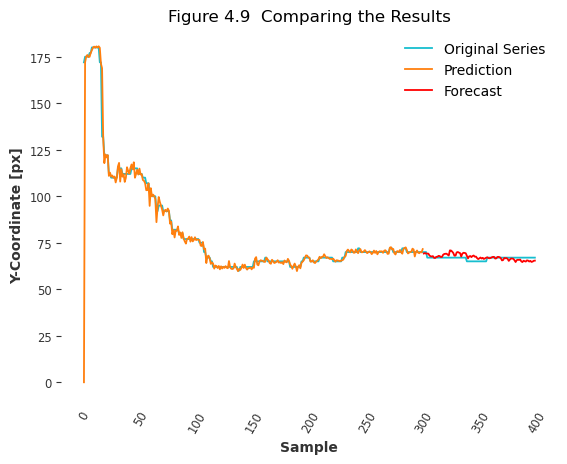

In [197]:
plt.plot(np.concatenate((Y_train, Y_test)), label = 'Original Series', color='tab:cyan')
plt.plot(arima.predict(), label = 'Prediction', color='tab:orange')
plt.plot(x_test_offset, Y_arima_forcast, color='r', label = 'Forecast')
plt.title('Figure 4.9  Comparing the Results')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();
plt.xlabel('Sample')
plt.ylabel('Y-Coordinate [px]')

## 4.4.1 Result: ARIMA model 
Now we put all forcasts together and show the results.

Text(0, 0.5, 'Y-Coordinate [px]')

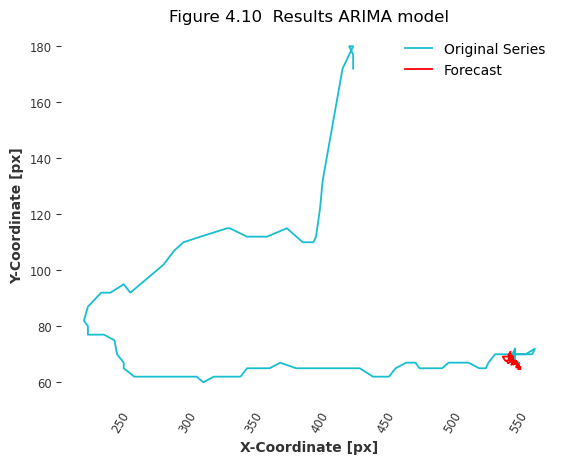

In [198]:
plt.plot(np.concatenate((X_train, X_test)), np.concatenate((Y_train, Y_test)), label = 'Original Series', color='tab:cyan')
plt.plot(X_arima_forcast, Y_arima_forcast, color='r', label = 'Forecast')
plt.title('Figure 4.10  Results ARIMA model')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();
plt.xlabel('X-Coordinate [px]')
plt.ylabel('Y-Coordinate [px]')

The plot shows a not very well selected test dataset, because the person is not strong moving on the end of the dataset.
Therefore the model should be trained and tested in an other time periode.<br>
A closer look on the moving plot (figure 3.4) shows the most moving is in first 40% of the dataset.

### Try new Dataset

In [199]:
# First of all we generate our train and test datasets for X coordinates as series
Y_train, Y_test = data.iloc[1:100]['Y'].values, data.iloc[101:200]['Y'].values

In [200]:
# lets plot the found values
arima = ARIMA(Y_train, order = (45, 1, 45)).fit()
forcast   = arima.forecast(len(Y_test))
preds     = arima.predict()
mse_train = mean_squared_error(preds, Y_train)
mae_train = mean_absolute_percentage_error(Y_train, preds)
mse_test  = mean_squared_error(forcast, Y_test)
mae_test  = mean_absolute_percentage_error(Y_test, forcast)
# print the last 5 predictions
print(preds[:5])
print('Train mean squart error             : %2.3f' %mse_train)
print('Train mean absolute percentage error:   %2.3f' %mae_train)
print('Test  mean squart error             :  %2.3f' %mse_test)
print('Test  mean absolute percentage error:   %2.3f' %mae_test)
#print(arma.summary())

[  0.         175.00003219 175.00148715 175.00013723 174.99980223]
Train mean squart error             : 326.438
Train mean absolute percentage error:   0.025
Test  mean squart error             :  60.873
Test  mean absolute percentage error:   0.107


In [201]:
# lets build a series fo x-coordinates to use for plotting the forcast on the right place
x_test_offset=[]
for i in range (101, 200):
    x_test_offset.append(i)
print(x_test_offset)
print(type(x_test_offset))

[101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
<class 'list'>


In [202]:
# Compute and save the forcast
Y_arima_forcast = arima.forecast(steps = len(Y_test))

Text(0, 0.5, 'Y-Coordinate [px]')

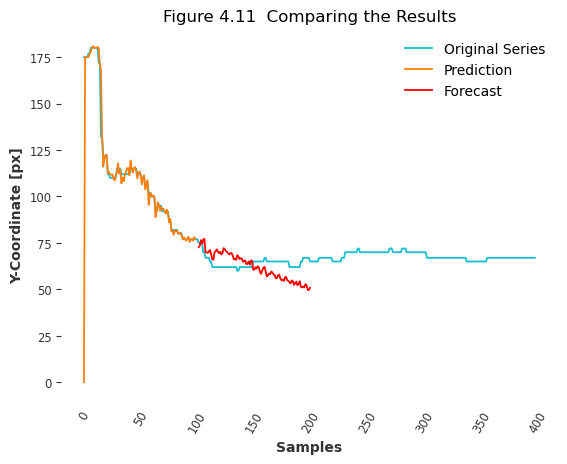

In [203]:
#plt.plot(np.concatenate((Y_train, Y_test)), label = 'Original Series', color='tab:cyan')
plt.plot(data.iloc[1:399]['Y'].values, label = 'Original Series', color='tab:cyan')
plt.plot(arima.predict(), label = 'Prediction', color='tab:orange')
plt.plot(x_test_offset, Y_arima_forcast, color='r', label = 'Forecast')
plt.title('Figure 4.11  Comparing the Results')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();
plt.xlabel('Samples')
plt.ylabel('Y-Coordinate [px]')

In [205]:
# set the forcast ratio
result_dict['forecast_ratio'][0] = 30/300  # around 30 pixel in the future are good while learning 300 pixel from the past

### 4.4.2 Results
The found ARIMA model performs not very well. The result is all the time a linear forcast.
Therefore the model have to use a rolling forecast. In a rolling forecast, the model is often retrained as new data becomes available.

### 4.4.3 Findings
The last plots shows the test errors MSE and MAPE compared to the differnet ARIMA parameters.<br>
The main findings are:
1. The plot in figure 3.6 and 3.7 shows the growing and falling of the MSE and MAPE with the order of used lags
2. The plot in figure 3.8 shows the exponential grow of the fitting time of the ARIMA model with growing the lags
3. More lags brings more information from the past in the forecast, and should be considered for the final application
4. There are two possibilities: less `lags (10,1,10)` with much faster fitting time or larger `lags (50,1,50)` with maybe better forecast

In [204]:
arima = ARIMA(Y_train, order = (45, 1, 45)).fit()
forcast   = arima.forecast(len(Y_test))
preds     = arima.predict()
mse_train = mean_squared_error(preds, Y_train)
mae_train = mean_absolute_percentage_error(Y_train, preds)
mse_test  = mean_squared_error(forcast, Y_test)
mae_test  = mean_absolute_percentage_error(Y_test, forcast)
# print the last 5 predictions
print(preds[:5])
print('Train mean squart error             : %2.3f' %mse_train)
print('Train mean absolute percentage error:   %2.3f' %mae_train)
print('Test  mean squart error             :  %2.3f' %mse_test)
print('Test  mean absolute percentage error:   %2.3f' %mae_test)
#print(arima.summary())

[  0.         175.00003219 175.00148715 175.00013723 174.99980223]
Train mean squart error             : 326.438
Train mean absolute percentage error:   0.025
Test  mean squart error             :  60.873
Test  mean absolute percentage error:   0.107


## 4.4 Model "LSTM"
One of the popular algorithm for time series applications is an `RNN network` specially `LSTM`. <br>
`LSTM long short time memory` are special `RNN recurrent neural networks` which solve the `vanishing gradient problem`. <br>Therefore the LSTM network will be used for further evaluation.

**LSTM** need for their use as special input format:<br>
The input data have to be organized in a **3D array** manner: <br>
samples, timesteps, features

In [81]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [82]:
# the following function creates the necessary sequences for using in LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

**Hyperparameter** <br>
in LSTM networks are: `timesteps`<br>
The bigger the timesteps the more the network filters the high frequencies in the sample dataset.

In [83]:
# let´s try in base line model with:
timesteps  = 3
batch_size = 30
lstm_size  = 15   # number of LSTM cells

In [84]:
# LSTM need the input date scaled 
# therefore we have to scale the data
scaler         = StandardScaler()
X_train_scaled = X_train.reshape(-1,1)
X_train_scaled = scaler.fit_transform(X_train_scaled)

In [85]:
X_train_scaled.shape

(300, 1)

In [86]:
# create the time series according to the input requirement of the LSTM network
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, timesteps)

In [87]:
X_train_lstm.shape

(297, 3, 1)

In [88]:
X_train_lstm[100]

array([[-1.42788799],
       [-1.42788799],
       [-1.35785772]])

In [89]:
y_train_lstm.shape

(297, 1)

In [90]:
y_train_lstm[100]

array([-1.35785772])

In [91]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(lstm_size, input_shape=(timesteps, 1)),
    tf.keras.layers.Dense(1)])

In [92]:
# Compile model
model.compile(loss='mse', optimizer='adam')

# Train model
model.fit(X_train_lstm, y_train_lstm, batch_size=batch_size, epochs=100, verbose=0) 

In [93]:
y_none_scaled = scaler.inverse_transform(y_train_lstm.reshape(-1,1))

In [94]:
y_none_scaled.shape

(297, 1)

In [95]:
# create the prediction and rescale it 
X_train_pred = scaler.inverse_transform(model.predict(X_train_lstm))

10/10 [==============================] - 0s 2ms/step


In [96]:
# lets see a prediction value
X_train_pred[100]

array([241.74847], dtype=float32)

In [97]:
# create the time series according to the input requirement of the LSTM network
test = scaler.fit_transform(X_test.reshape(-1,1))
X_test_lstm, y_test_lstm = create_sequences(test, timesteps)
X_test_pred = scaler.inverse_transform(model.predict(X_test_lstm))

3/3 [==============================] - 0s 1ms/step


In [98]:
X_test_lstm[70]

array([[0.29649973],
       [0.29649973],
       [0.29649973]])

In [99]:
X_test_lstm.shape

(96, 3, 1)

In [100]:
X_train_lstm.shape

(297, 3, 1)

In [101]:
# generate the offset for the test sample forecast
x_test_offset = []
for i in range (len(X_train_lstm), len(X_test_lstm) + len(X_train_lstm)):
    x_test_offset.append(i)

In [102]:
y_none_scaled[0]

array([425.])

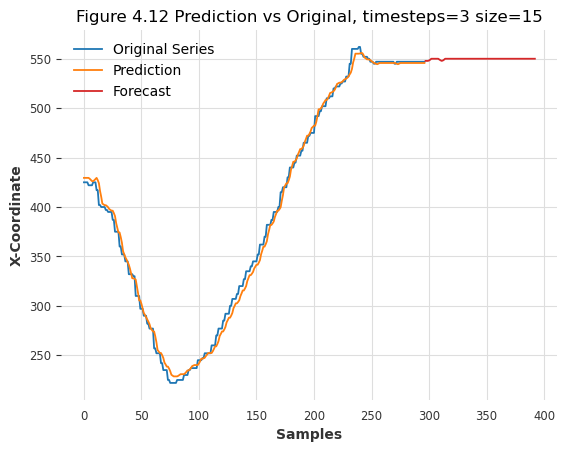

In [103]:
plt.plot(y_none_scaled, label = 'Original Series', color='tab:blue')
plt.plot(X_train_pred, label='Prediction', color='tab:orange')
plt.plot(x_test_offset, X_test_pred, label='Forecast', color='tab:red')
plt.title('Figure 4.12 Prediction vs Original, timesteps=' + str(timesteps) +' size=' + str(lstm_size))
plt.legend();
plt.ylabel('X-Coordinate')
plt.xlabel('Samples')
plt.show()

In [104]:
# lets plot the result values
mse_train = mean_squared_error(X_train_pred, X_train[:len(X_train_pred)])
mae_train = mean_absolute_percentage_error(X_train[:len(X_train_pred)], X_train_pred)
mse_test  = mean_squared_error(X_test_pred, X_test[:len(X_test_pred)])
mae_test  = mean_absolute_percentage_error(X_test[:len(X_test_pred)], X_test_pred)
# print the last 5 predictions
print(X_test_pred[:5])
print('Train mean squart error             : %2.4f' %mse_train)
print('Train mean absolute percentage error:  %2.4f' %mae_train)
print('Test  mean squart error             :  %2.4f' %mse_test)
print('Test  mean absolute percentage error:  %2.4f' %mae_test)

[[547.8648 ]
 [547.8648 ]
 [547.8648 ]
 [548.2645 ]
 [549.02435]]
Train mean squart error             : 26.1475
Train mean absolute percentage error:  0.0112
Test  mean squart error             :  0.1824
Test  mean absolute percentage error:  0.0003


## 4.4.1 Hyperparameter Tuning

There are different hyperparameter for tuning the LSTM network:<br>
- timesteps
- network size 
- training epochs

In [105]:
# set the search parameter for the grid search
Yres_dict = {'timesteps'      : [1, 2, 3, 5, 10, 20, 50],
            'lstm_size'       : [3, 5, 10, 25, 50, 100], 
            'epochs'          : [10, 25, 50, 100, 300, 1000], 
            'train score MSE' : [0, 0, 0, 0, 0, 0, 0],
            'test score MSE'  : [0, 0, 0, 0, 0, 0, 0],
            'train score MAPE': [0, 0, 0, 0, 0, 0, 0],
            'test score MAPE' : [0, 0, 0, 0, 0, 0, 0],
            'fit time'        : [0, 0, 0, 0, 0, 0, 0]}

### 4.4.1.1 Tune: timesteps

In [106]:
# lets try a grid search with the differnet parameters
lstm_size = 32
for i in range (len(Yres_dict['timesteps'])):
    model = tf.keras.Sequential([
            tf.keras.layers.LSTM(lstm_size, input_shape=(Yres_dict['timesteps'][i], 1)),
            tf.keras.layers.Dense(1)])
    model.compile(loss='mse', optimizer='adam')
    # create the time series according to the input requirement of the LSTM network
    X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, Yres_dict['timesteps'][i])
    start_time  = time.time()
    model.fit(X_train_lstm, y_train_lstm, batch_size=batch_size, epochs=100, verbose=0)
    Yres_dict['fit time'][i] = time.time() - start_time
    
    #Prediction
    train         = scaler.fit_transform(X_train.reshape(-1,1))
    X_train_pred  = scaler.inverse_transform(model.predict(X_train_lstm))
        
    #Forcasting
    test          = scaler.fit_transform(X_test.reshape(-1,1))
    X_test_lstm, y_test_lstm = create_sequences(test, Yres_dict['timesteps'][i])
    X_test_pred   = scaler.inverse_transform(model.predict(X_test_lstm))
    
    Yres_dict['train score MSE'][i]  = mean_squared_error(X_train_pred, X_train[:len(X_train_pred)])
    Yres_dict['test score MSE'][i]   = mean_absolute_percentage_error(X_train[:len(X_train_pred)], X_train_pred)
    Yres_dict['train score MAPE'][i] = mean_squared_error(X_test_pred, X_test[:len(X_test_pred)])
    Yres_dict['test score MAPE'][i]  = mean_absolute_percentage_error(X_test[:len(X_test_pred)], X_test_pred)
    
    print('Network with timesteps : '+ str(Yres_dict['timesteps'][i]))
    print('Train MSE  : %02.3f' %Yres_dict['train score MSE'][i])
    print('Test  MSE  :  %02.3f' %Yres_dict['test score MSE'][i])
    print('Train MAPE :   %02.3f' %Yres_dict['train score MAPE'][i])
    print('Test  MAPE :   %02.3f' %Yres_dict['test score MAPE'][i])
    print('Fit time   :   %02.3f sec' %Yres_dict['fit time'][i])
    print()

4/4 [==============================] - 0s 1ms/step
Network with timesteps : 1
Train MSE  : 6.668
Test  MSE  :  0.006
Train MAPE :   0.034
Test  MAPE :   0.000
Fit time   :   2.880 sec

4/4 [==============================] - 0s 2ms/step
Network with timesteps : 2
Train MSE  : 11.686
Test  MSE  :  0.008
Train MAPE :   0.072
Test  MAPE :   0.000
Fit time   :   3.008 sec

3/3 [==============================] - 0s 946us/step
Network with timesteps : 3
Train MSE  : 14.695
Test  MSE  :  0.008
Train MAPE :   0.125
Test  MAPE :   0.000
Fit time   :   3.148 sec

3/3 [==============================] - 0s 1ms/step
Network with timesteps : 5
Train MSE  : 39.198
Test  MSE  :  0.014
Train MAPE :   0.374
Test  MAPE :   0.000
Fit time   :   3.313 sec

3/3 [==============================] - 0s 2ms/step
Network with timesteps : 10
Train MSE  : 424.114
Test  MSE  :  0.050
Train MAPE :   1.244
Test  MAPE :   0.001
Fit time   :   3.799 sec

3/3 [==============================] - 0s 1ms/step
Network with tim

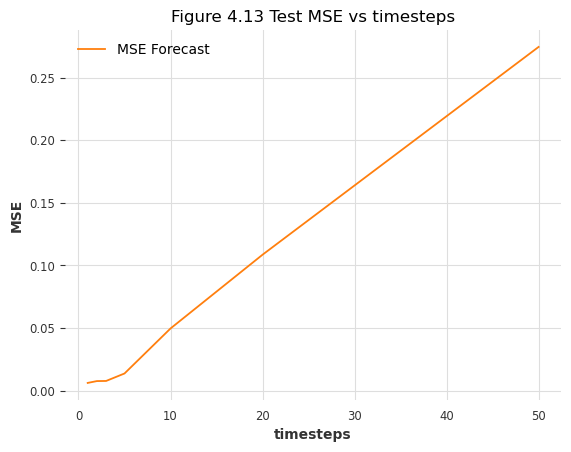

In [107]:
# plot the mse
#plt.plot(Yres_dict['timesteps'], Yres_dict['train score MSE'], label = 'MSE Prediction', color='tab:blue')
plt.plot(Yres_dict['timesteps'], Yres_dict['test score MSE'], label = 'MSE Forecast', color='tab:orange')
plt.title('Figure 4.13 Test MSE vs timesteps')
plt.legend();
plt.ylabel('MSE')
plt.xlabel('timesteps')
plt.show()

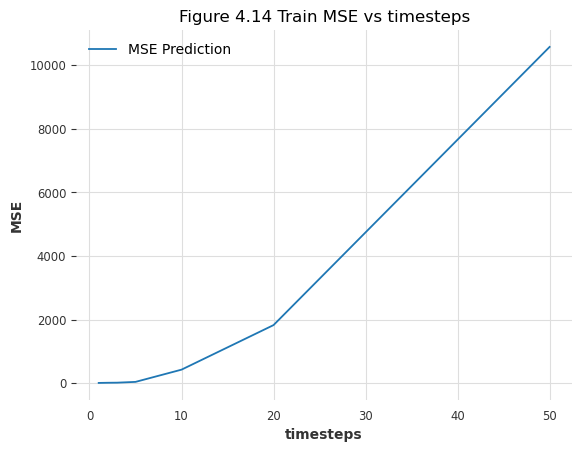

In [108]:
# plot the mse
plt.plot(Yres_dict['timesteps'], Yres_dict['train score MSE'], label = 'MSE Prediction', color='tab:blue')
#plt.plot(Yres_dict['timesteps'], Yres_dict['test score MSE'], label = 'MSE Forecast', color='tab:orange')
plt.title('Figure 4.14 Train MSE vs timesteps')
plt.legend();
plt.ylabel('MSE')
plt.xlabel('timesteps')
plt.show()

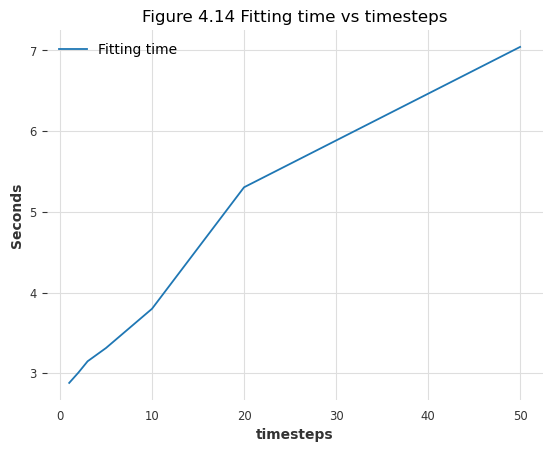

In [109]:
# plot the mse
plt.plot(Yres_dict['timesteps'], Yres_dict['fit time'], label = 'Fitting time', color='tab:blue')
plt.title('Figure 4.14 Fitting time vs timesteps')
plt.legend();
plt.ylabel('Seconds')
plt.xlabel('timesteps')
plt.show()

### 4.4.1.2 Findings: timesteps
- The MSE is constant growing with increasing the timesteps. <br>
The more the network uses the past datapoints (timesteps) the more the network looks like a convolution <br>
filter building the trend of the data.<br>
Lets use `timestep = 1` for further evaluation.<br><br>
- The fitting time grow linear with the size of timesteps.

### 4.4.1.2 Tune: LSTM size

In [110]:
# set the search parameter for the grid search
Yres_dict = {'timesteps'      : [1, 2, 3, 5, 10, 20, 50],
            'lstm_size'       : [4, 8, 16, 32, 48, 64, 96], 
            'epochs'          : [10, 25, 50, 100, 300, 500, 1000], 
            'train score MSE' : [0, 0, 0, 0, 0, 0, 0],
            'test score MSE'  : [0, 0, 0, 0, 0, 0, 0],
            'train score MAPE': [0, 0, 0, 0, 0, 0, 0],
            'test score MAPE' : [0, 0, 0, 0, 0, 0, 0],
            'fit time'        : [0, 0, 0, 0, 0, 0, 0]}

In [111]:
# lets try a grid search with the differnet parameters
timesteps = 1
for i in range (len(Yres_dict['lstm_size'])):
    model = tf.keras.Sequential([
            tf.keras.layers.LSTM(Yres_dict['lstm_size'][i], input_shape=(timesteps, 1)),
            tf.keras.layers.Dense(1)])
    model.compile(loss='mse', optimizer='adam')
    # create the time series according to the input requirement of the LSTM network
    X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, timesteps)
    start_time  = time.time()
    model.fit(X_train_lstm, y_train_lstm, batch_size=batch_size, epochs=100, verbose=0)
    Yres_dict['fit time'][i] = time.time() - start_time
    
    #Prediction
    train         = scaler.fit_transform(X_train.reshape(-1,1))
    X_train_pred  = scaler.inverse_transform(model.predict(X_train_lstm))
        
    #Forcasting
    test          = scaler.fit_transform(X_test.reshape(-1,1))
    X_test_lstm, y_test_lstm = create_sequences(test, timesteps)
    X_test_pred   = scaler.inverse_transform(model.predict(X_test_lstm))
    
    Yres_dict['train score MSE'][i]  = mean_squared_error(X_train_pred, X_train[:len(X_train_pred)])
    Yres_dict['test score MSE'][i]   = mean_absolute_percentage_error(X_train[:len(X_train_pred)], X_train_pred)
    Yres_dict['train score MAPE'][i] = mean_squared_error(X_test_pred, X_test[:len(X_test_pred)])
    Yres_dict['test score MAPE'][i]  = mean_absolute_percentage_error(X_test[:len(X_test_pred)], X_test_pred)
    
    print('Network with lstm_size : '+ str(Yres_dict['lstm_size'][i]))
    print('Train MSE  : %02.3f' %Yres_dict['train score MSE'][i])
    print('Test  MSE  :  %02.3f' %Yres_dict['test score MSE'][i])
    print('Train MAPE :   %02.3f' %Yres_dict['train score MAPE'][i])
    print('Test  MAPE :   %02.3f' %Yres_dict['test score MAPE'][i])
    print('Fit time   :   %02.3f sec' %Yres_dict['fit time'][i])
    print()

4/4 [==============================] - 0s 1ms/step
Network with lstm_size : 4
Train MSE  : 130.787
Test  MSE  :  0.029
Train MAPE :   0.190
Test  MAPE :   0.000
Fit time   :   2.875 sec

4/4 [==============================] - 0s 1ms/step
Network with lstm_size : 8
Train MSE  : 58.185
Test  MSE  :  0.019
Train MAPE :   0.111
Test  MAPE :   0.000
Fit time   :   2.899 sec

4/4 [==============================] - 0s 897us/step
Network with lstm_size : 16
Train MSE  : 16.373
Test  MSE  :  0.010
Train MAPE :   0.066
Test  MAPE :   0.000
Fit time   :   2.834 sec

4/4 [==============================] - 0s 899us/step
Network with lstm_size : 32
Train MSE  : 4.919
Test  MSE  :  0.005
Train MAPE :   0.027
Test  MAPE :   0.000
Fit time   :   2.856 sec

4/4 [==============================] - 0s 783us/step
Network with lstm_size : 48
Train MSE  : 2.735
Test  MSE  :  0.004
Train MAPE :   0.017
Test  MAPE :   0.000
Fit time   :   3.013 sec

4/4 [==============================] - 0s 0s/step
Network with

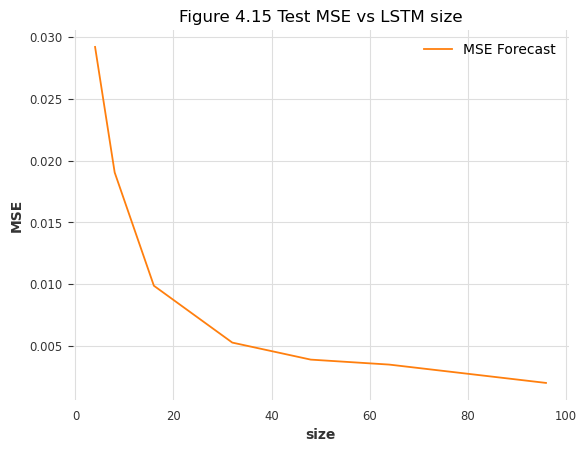

In [112]:
# plot the test mse
plt.plot(Yres_dict['lstm_size'], Yres_dict['test score MSE'], label = 'MSE Forecast', color='tab:orange')
plt.title('Figure 4.15 Test MSE vs LSTM size')
plt.legend();
plt.ylabel('MSE')
plt.xlabel('size')
plt.show()

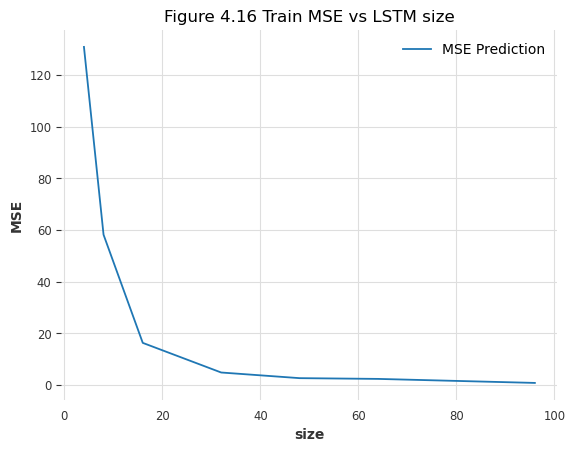

In [113]:
# plot the train mse
plt.plot(Yres_dict['lstm_size'], Yres_dict['train score MSE'], label = 'MSE Prediction', color='tab:blue')
plt.title('Figure 4.16 Train MSE vs LSTM size')
plt.legend();
plt.ylabel('MSE')
plt.xlabel('size')
plt.show()

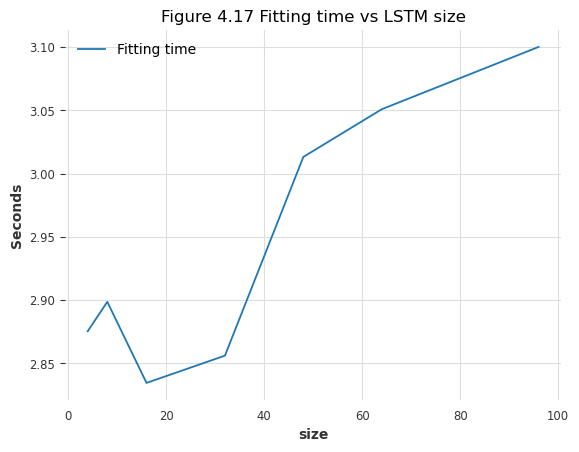

In [114]:
# plot the mse
plt.plot(Yres_dict['lstm_size'], Yres_dict['fit time'], label = 'Fitting time', color='tab:blue')
plt.title('Figure 4.17 Fitting time vs LSTM size')
plt.legend();
plt.ylabel('Seconds')
plt.xlabel('size')
plt.show()

### 4.4.2.2 Findings: LSTM size
The MSE decreases very fast to his minimum with around 16 neurons.<br>
Will use `48 neurons` or units for further evaluation.

### 4.4.3.1 Tune: Epochs

In [115]:
# set the search parameter for the grid search
Yres_dict = {'timesteps'      : [1, 2, 3, 5, 10, 20, 50],
            'lstm_size'       : [1, 3, 5, 10, 20, 100, 200], 
            'epochs'          : [30, 50, 100, 150, 200, 250, 300], 
            'train score MSE' : [0, 0, 0, 0, 0, 0, 0],
            'test score MSE'  : [0, 0, 0, 0, 0, 0, 0],
            'train score MAPE': [0, 0, 0, 0, 0, 0, 0],
            'test score MAPE' : [0, 0, 0, 0, 0, 0, 0],
            'fit time'        : [0, 0, 0, 0, 0, 0, 0]}

In [132]:
# lets try a grid search with the differnet parameters
timesteps = 1
lstm_size = 48
for i in range (len(Yres_dict['epochs'])):
    model = tf.keras.Sequential([
            tf.keras.layers.LSTM(lstm_size, input_shape=(timesteps, 1)),
            tf.keras.layers.Dense(1)])
    model.compile(loss='mse', optimizer='adam')
    # create the time series according to the input requirement of the LSTM network
    X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, timesteps)
    start_time  = time.time()
    model.fit(X_train_lstm, y_train_lstm, batch_size=batch_size, epochs=Yres_dict['epochs'][i], verbose=0)
    Yres_dict['fit time'][i] = time.time() - start_time
    
    #Prediction
    train         = scaler.fit_transform(X_train.reshape(-1,1))
    X_train_pred  = scaler.inverse_transform(model.predict(X_train_lstm))
    
    #Forcasting
    test = scaler.fit_transform(X_test.reshape(-1,1))
    X_test_lstm, y_test_lstm = create_sequences(test, timesteps)
    X_test_pred   = scaler.inverse_transform(model.predict(X_test_lstm))
    
    Yres_dict['train score MSE'][i]  = mean_squared_error(X_train_pred, X_train[:len(X_train_pred)])
    Yres_dict['test score MSE'][i]   = mean_absolute_percentage_error(X_train[:len(X_train_pred)], X_train_pred)
    Yres_dict['train score MAPE'][i] = mean_squared_error(X_test_pred, X_test[:len(X_test_pred)])
    Yres_dict['test score MAPE'][i]  = mean_absolute_percentage_error(X_test[:len(X_test_pred)], X_test_pred)
    
    print('Network with epochs : '+ str(Yres_dict['epochs'][i]))
    print('Train MSE  :   %02.3f' %Yres_dict['train score MSE'][i])
    print('Test  MSE  :   %02.3f' %Yres_dict['test score MSE'][i])
    print('Train MAPE :   %02.3f' %Yres_dict['train score MAPE'][i])
    print('Test  MAPE :   %02.3f' %Yres_dict['test score MAPE'][i])
    print('Fit time   :   %02.3f sec' %Yres_dict['fit time'][i])
    print()

10/10 [==============================] - 0s 875us/step
Network with epochs : 30
Train MSE  :   875.001
Test  MSE  :   0.090
Train MAPE :   1947.636
Test  MAPE :   0.096
Fit time   :   2.061 sec

10/10 [==============================] - 0s 735us/step
Network with epochs : 50
Train MSE  :   60.871
Test  MSE  :   0.023
Train MAPE :   235.096
Test  MAPE :   0.032
Fit time   :   2.150 sec

10/10 [==============================] - 0s 769us/step
Network with epochs : 100
Train MSE  :   6.436
Test  MSE  :   0.007
Train MAPE :   88.551
Test  MAPE :   0.017
Fit time   :   2.345 sec

10/10 [==============================] - 0s 777us/step
Network with epochs : 150
Train MSE  :   5.509
Test  MSE  :   0.007
Train MAPE :   92.409
Test  MAPE :   0.017
Fit time   :   2.573 sec

10/10 [==============================] - 0s 0s/step
Network with epochs : 200
Train MSE  :   5.878
Test  MSE  :   0.007
Train MAPE :   82.010
Test  MAPE :   0.017
Fit time   :   3.477 sec

10/10 [==============================] 

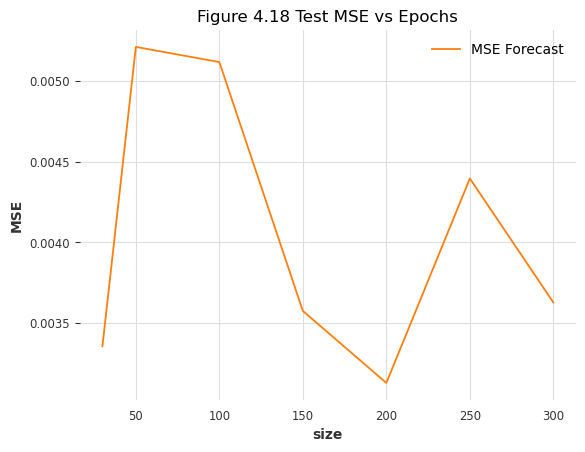

In [117]:
# plot the test mse
plt.plot(Yres_dict['epochs'], Yres_dict['test score MSE'], label = 'MSE Forecast', color='tab:orange')
plt.title('Figure 4.18 Test MSE vs Epochs')
plt.legend();
plt.ylabel('MSE')
plt.xlabel('size')
plt.show()

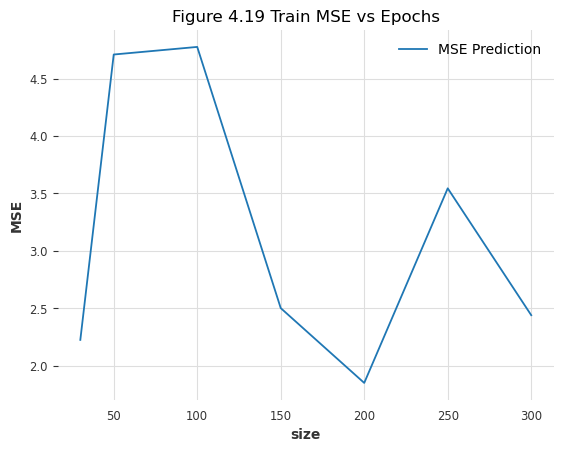

In [118]:
# plot the train mse
plt.plot(Yres_dict['epochs'], Yres_dict['train score MSE'], label = 'MSE Prediction', color='tab:blue')
plt.title('Figure 4.19 Train MSE vs Epochs')
plt.legend();
plt.ylabel('MSE')
plt.xlabel('size')
plt.show()

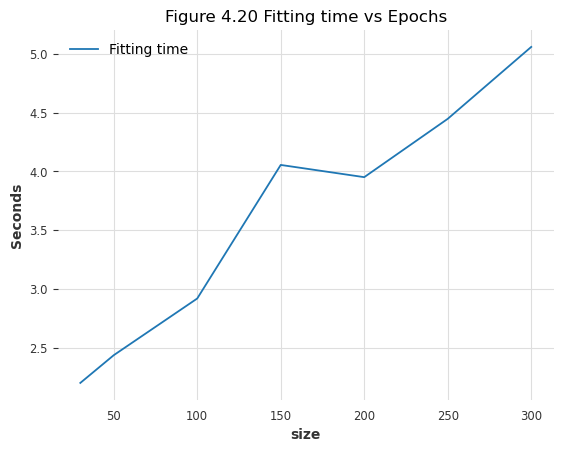

In [119]:
# plot the mse
plt.plot(Yres_dict['epochs'], Yres_dict['fit time'], label = 'Fitting time', color='tab:blue')
plt.title('Figure 4.20 Fitting time vs Epochs')
plt.legend();
plt.ylabel('Seconds')
plt.xlabel('size')
plt.show()

### 4.4.3.2 Findings: Epoch
The MSE reach his minimum around 50 epochs.<br>
Will use `50 epochs` for further evaluation.

**Final results:<br>**
1.    timesteps = 1 <br>
2.    size      = 48 <br>
3.    epochs    = 50

### 4.4.4 Final Model

In [214]:
split = 100 # samples
X_train, X_test = np.array(data.iloc[0:split]['X']), np.array(data.iloc[split:-1]['X'])

In [215]:
# lets try a grid search with the differnet parameters
timesteps = 1
lstm_size = 48
epochs    = 50
model = tf.keras.Sequential([
        tf.keras.layers.LSTM(lstm_size, input_shape=(timesteps, 1)),
        tf.keras.layers.Dense(1)])
model.compile(loss='mse', optimizer='adam')
# create the time series according to the input requirement of the LSTM network
X_train_scaled = scaler.fit_transform(X_train.reshape(-1,1))
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, timesteps)
start_time = time.time()
model.fit(X_train_lstm, y_train_lstm, batch_size=batch_size, epochs=epochs, verbose=0)
fit_time   = time.time() - start_time

In [216]:
#Prediction
# reset the scaler
train         = scaler.fit_transform(X_train.reshape(-1,1))
X_train_pred  = scaler.inverse_transform(model.predict(X_train_lstm))
    
#Forcasting
test          = scaler.fit_transform(X_test.reshape(-1,1))
X_test_lstm, y_test_lstm = create_sequences(test, timesteps)
X_test_pred   = scaler.inverse_transform(model.predict(X_test_lstm))
    
# lets plot the result values
mse_train = mean_squared_error(X_train_pred, X_train[:len(X_train_pred)])
mae_train = mean_absolute_percentage_error(X_train[:len(X_train_pred)], X_train_pred)
mse_test  = mean_squared_error(X_test_pred, X_test[:len(X_test_pred)])
mae_test  = mean_absolute_percentage_error(X_test[:len(X_test_pred)], X_test_pred)
# print the last 5 predictions
print(X_test_pred[:5])
print('Train mean squart error             : %2.4f' %mse_train)
print('Train mean absolute percentage error:  %2.4f' %mae_train)
print('Test  mean squart error             :  %2.4f' %mse_test)
print('Test  mean absolute percentage error:  %2.4f' %mae_test)
print()

10/10 [==============================] - 0s 874us/step
[[321.3424 ]
 [321.3424 ]
 [324.32513]
 [324.32513]
 [324.32513]]
Train mean squart error             : 178.5110
Train mean absolute percentage error:  0.0408
Test  mean squart error             :  756.4570
Test  mean absolute percentage error:  0.0567



In [217]:
# generate the offset for the test sample forecast
x_test_offset = []
for i in range (len(X_train_lstm), len(X_test_lstm) + len(X_train_lstm)):
    x_test_offset.append(i)

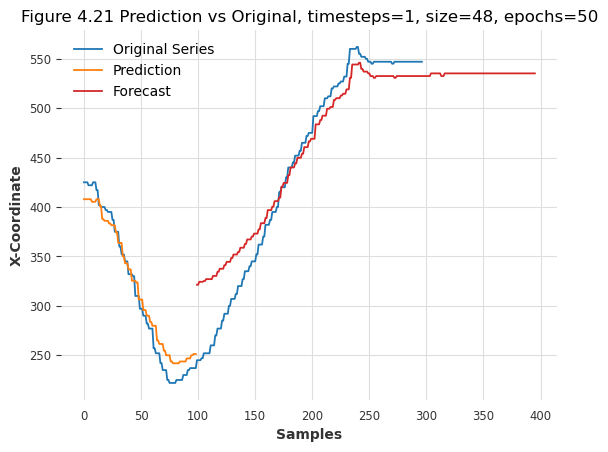

In [218]:
plt.plot(y_none_scaled, label = 'Original Series', color='tab:blue')
plt.plot(X_train_pred, label='Prediction', color='tab:orange')
plt.plot(x_test_offset, X_test_pred, label='Forecast', color='tab:red')
plt.title('Figure 4.21 Prediction vs Original, timesteps=' + str(timesteps) +', size=' + str(lstm_size)+ ', epochs=' + str(epochs))
plt.legend();
plt.ylabel('X-Coordinate')
plt.xlabel('Samples')
plt.show()

### 4.4.5 Use final model
Lets try the current model with other data.

In [219]:
split = 100 # samples
Y_train, Y_test = np.array(data.iloc[0:split]['Y']), np.array(data.iloc[split:-1]['Y'])

In [220]:
# lets try a grid search with the different parameters
timesteps = 1
lstm_size = 64
epochs    = 150
model = tf.keras.Sequential([
        tf.keras.layers.LSTM(lstm_size, input_shape=(timesteps, 1)),
        tf.keras.layers.Dense(1)])
model.compile(loss='mse', optimizer='adam')
# create the time series according to the input requirement of the LSTM network
Y_train_scaled = scaler.fit_transform(Y_train.reshape(-1,1))
Y_train_lstm, y_train_lstm = create_sequences(Y_train_scaled, timesteps)
model.fit(Y_train_lstm, y_train_lstm, batch_size=batch_size, epochs=epochs, verbose=0)

In [221]:
#Prediction
# reset the scaler
train         = scaler.fit_transform(Y_train.reshape(-1,1))
Y_train_pred  = scaler.inverse_transform(model.predict(Y_train_lstm))
    
#Forcasting
test          = scaler.fit_transform(Y_test.reshape(-1,1))
Y_test_lstm, y_test_lstm = create_sequences(test, timesteps)
Y_test_pred   = scaler.inverse_transform(model.predict(Y_test_lstm))
    
# lets plot the result values
mse_train = mean_squared_error(Y_train_pred, Y_train[:len(Y_train_pred)])
mae_train = mean_absolute_percentage_error(Y_train[:len(Y_train_pred)], Y_train_pred)
mse_test  = mean_squared_error(Y_test_pred, Y_test[:len(Y_test_pred)])
mae_test  = mean_absolute_percentage_error(Y_test[:len(Y_test_pred)], Y_test_pred)
# print the last 5 predictions
print(Y_test_pred[:5])
print('Train mean squart error             :  %2.4f' %mse_train)
print('Train mean absolute percentage error:  %2.4f' %mae_train)
print('Test  mean squart error             :  %2.4f' %mse_test)
print('Test  mean absolute percentage error:  %2.4f' %mae_test)
print()

10/10 [==============================] - 0s 903us/step
[[75.907196]
 [75.907196]
 [74.428856]
 [74.428856]
 [74.428856]]
Train mean squart error             :  2.1035
Train mean absolute percentage error:  0.0108
Test  mean squart error             :  0.0451
Test  mean absolute percentage error:  0.0025



In [222]:
# store the results in our global result dictionary
result_dict['train MSE'][1]        = mse_train
result_dict['test MSE'][1]         = mae_train
result_dict['train MAPE'][1]       = mse_test
result_dict['test MAPE'][1]        = mae_test
result_dict['average fit time'][1] = fit_time

In [223]:
# lets build a series fo x-coordinates to use for plotting the forcast on the right place
y_test_offset=[]
for i in range (split, split+len(Y_test_pred)):
    y_test_offset.append(i)

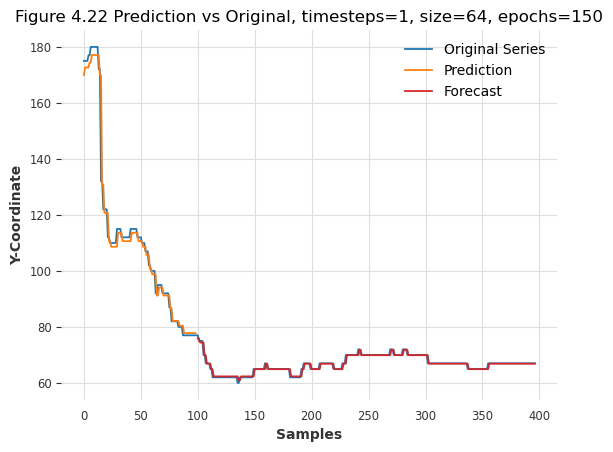

In [224]:
# lets plot the results
plt.plot(data.iloc[1:-1]['Y'].values, label = 'Original Series', color='tab:blue')
plt.plot(Y_train_pred, label='Prediction', color='tab:orange')
plt.plot(y_test_offset, Y_test_pred, label='Forecast', color='tab:red')
plt.title('Figure 4.22 Prediction vs Original, timesteps=' + str(timesteps) +', size=' + str(lstm_size)+ ', epochs=' + str(epochs))
plt.legend();
plt.ylabel('Y-Coordinate')
plt.xlabel('Samples')
plt.show()

In [225]:
result_dict['forecast_ratio'][1]   = 400/100  #forecast of 400 pixel while learning only 100 pixel

Text(0, 0.5, 'Y-Coordinate [px]')

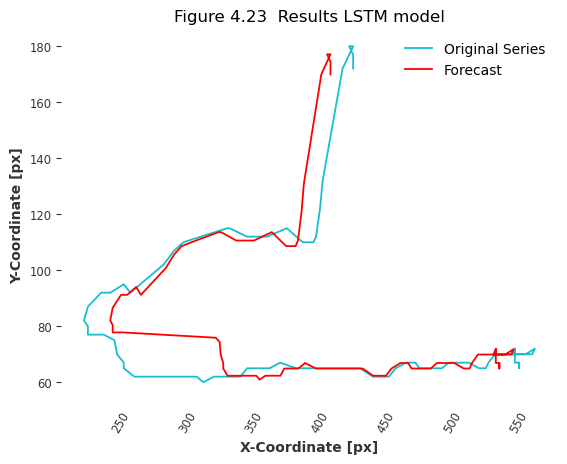

In [226]:
plt.plot(np.concatenate((X_train, X_test))[0:398], np.concatenate((Y_train, Y_test)), label = 'Original Series', color='tab:cyan')
plt.plot(np.concatenate((X_train_pred, X_test_pred)), np.concatenate((Y_train_pred, Y_test_pred)), color='r', label = 'Forecast')
plt.title('Figure 4.23  Results LSTM model')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();
plt.xlabel('X-Coordinate [px]')
plt.ylabel('Y-Coordinate [px]')

### 4.4.5.1 Findings: Final Model
The final LSTM model perfoms very well in the forcasting. <br>
The figure 4.22 shows the short training set of 100 samples and the resulting forcast of 300 points.<br>
The forecast is exactly like the original data.<br>
The forecast to learning ratio is 300/100 = 3 is very good.

# 5.) Evaluation
Now we will evaluate the results of the created models.

In [231]:
print('List 5.1')
print('--------')
print()
for i in (0, len(result_dict['model'])-1):
    print('Model             : '+ result_dict['model'][i])
    print('  Train MSE       : '+ str(round(result_dict['train MSE'][i], 4)))
    print('  Test  MSE       : '+ str(round(result_dict['test MSE'][i], 4)))
    print('  Fitting time    : '+ str(round(result_dict['average fit time'][i], 4)) + ' sec')
    print('  Forecast ratio  : '+ str(round(result_dict['forecast_ratio'][i], 4)))
    print('')

List 5.1
--------

Model             : ARIMA
  Train MSE       : 105.5417
  Test  MSE       : 0.0171
  Fitting time    : 56.1372 sec
  Forecast ratio  : 0.1

Model             : LSTM
  Train MSE       : 2.1035
  Test  MSE       : 0.0108
  Fitting time    : 2.121 sec
  Forecast ratio  : 4.0



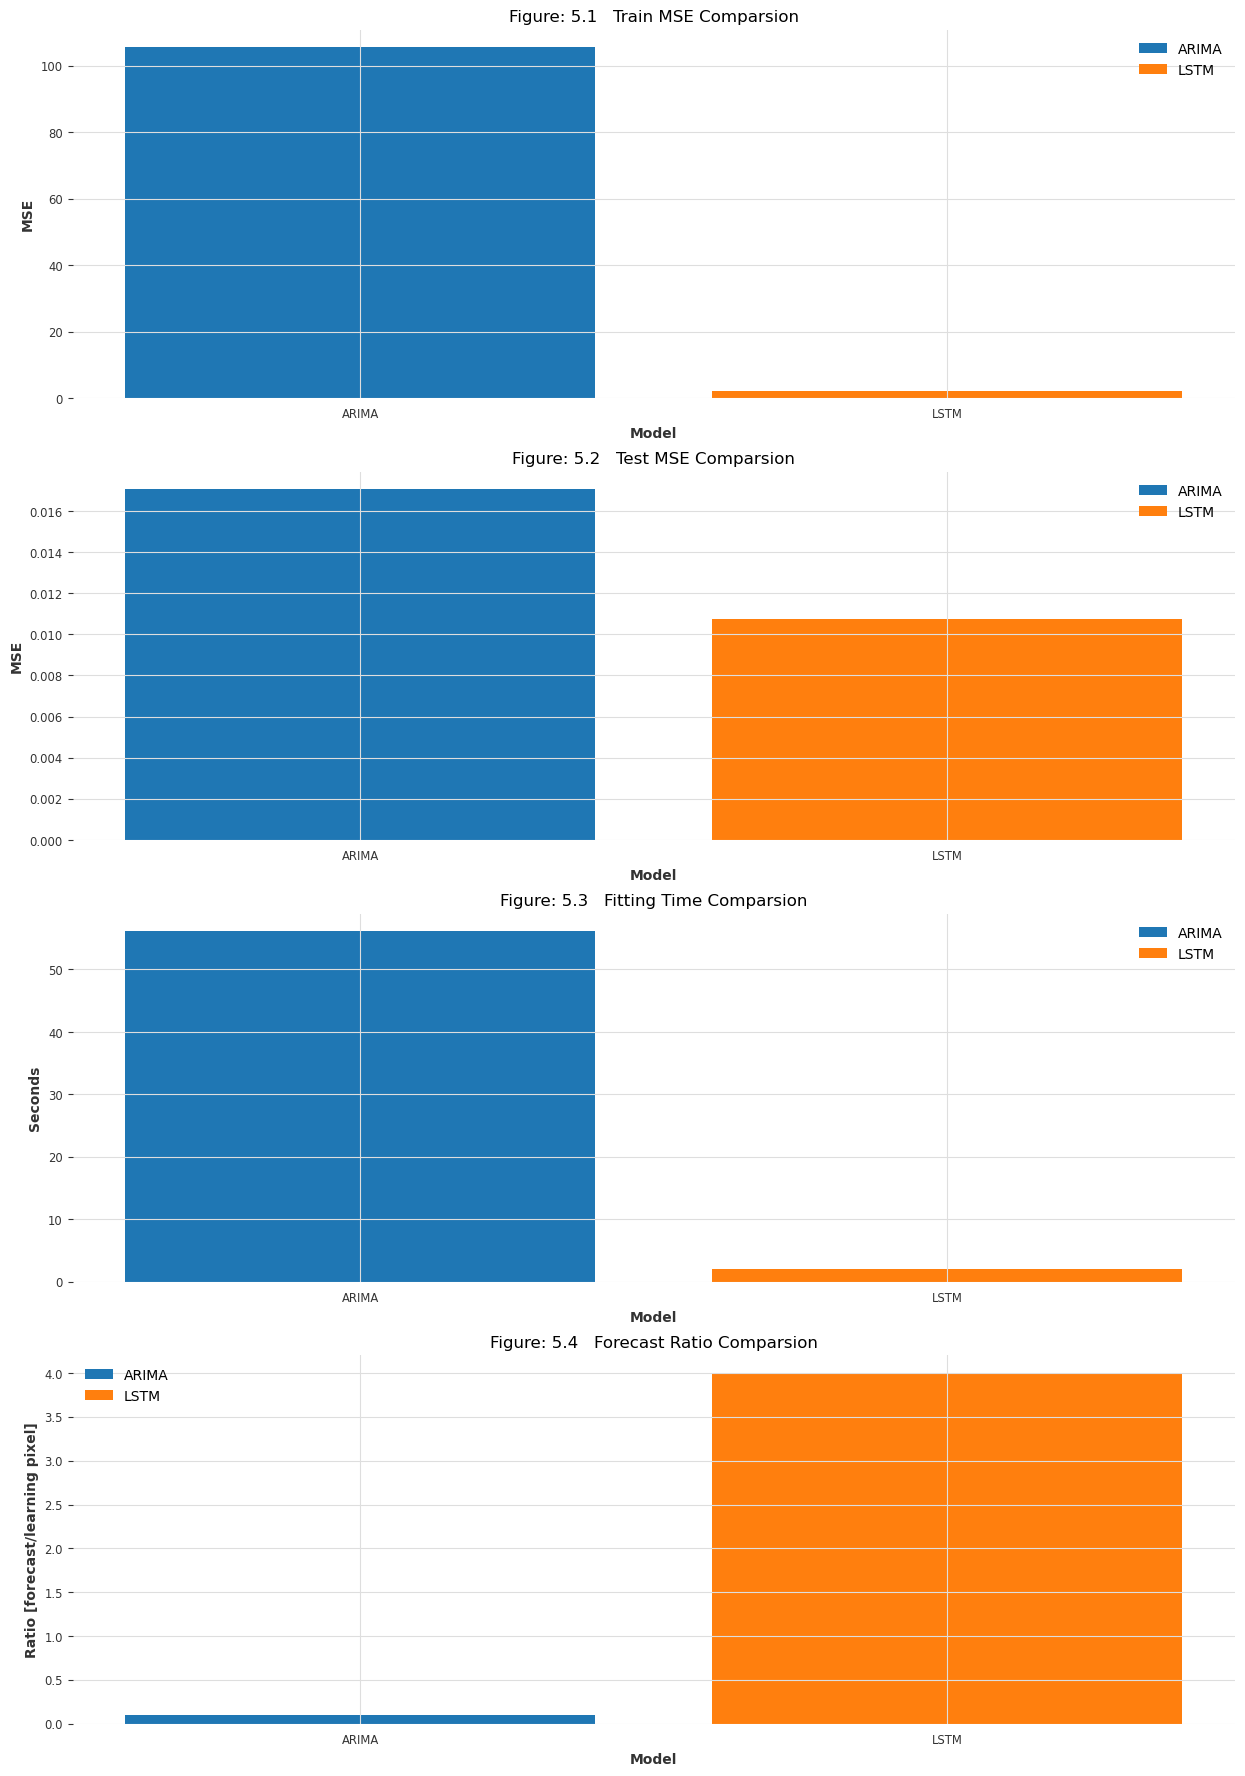

In [228]:
# Lets plot the fit time to see the model performance with the differnent hyperparameters
bar_colors = ['tab:blue', 'tab:orange']
fig, ax = plt.subplots(4, 1, figsize = (15, 22))
ax[0].bar(result_dict['model'], result_dict['train MSE'], label=result_dict['model'], color=bar_colors)
ax[0].set_title('Figure: 5.1   Train MSE Comparsion')
ax[0].set(xlabel='Model', ylabel='MSE')
ax[0].legend(loc='upper right')
ax[1].bar(result_dict['model'], result_dict['test MSE'], label=result_dict['model'], color=bar_colors)
ax[1].set_title('Figure: 5.2   Test MSE Comparsion')
ax[1].set(xlabel='Model', ylabel='MSE')
ax[1].legend(loc='upper right')
ax[2].bar(result_dict['model'], result_dict['average fit time'], label=result_dict['model'], color=bar_colors)
ax[2].set_title('Figure: 5.3   Fitting Time Comparsion')
ax[2].set(xlabel='Model', ylabel='Seconds')
ax[2].legend(loc='upper right')
ax[3].bar(result_dict['model'], result_dict['forecast_ratio'], label=result_dict['model'], color=bar_colors)
ax[3].set_title('Figure: 5.4   Forecast Ratio Comparsion')
ax[3].set(xlabel='Model', ylabel='Ratio [forecast/learning pixel]')
ax[3].legend(loc='upper left')
plt.show()

## 5.1) Evaluation: Facts



- A good ARIMA model need a high degree of lags.<br>
- A high degree of lags need a lot of fitting time.<br>
- A high fitting time is in most of the cases not possible, because of a forecast longer than 5 seconds is not applicable from the quality side.
- Comparing the two models with the MSE (mean squared error) the LSTM model shows better results (see List 5.1 and Figure 5.1).<br>
- Comparing the fitting or leaning time of the two differnet models also the LSTM model performs much better (see List 5.1 and  Figure 5.3). The LSTM model can fit in arround 2 seconds while the ARIMA model need arround 56 seconds. So the `LSTM` fit arround `20 times` faster. 
- Comparing the forecast ability the LSTM model performs much better (see List 5.1 and Figure 5.4). `LSTM` performs `40 times` better than the ARIMA model.  

## 5.2) Next Steps
To get a better understanding, it could be interested to change the input data:
- with different moving speeds during the movement
- with many change of the moving directions

It could be interested to evaluate a `Kalman-Predictor` model and comparing with the LSTM.


# 6.) Deployment
The LSTM model is the best choice for fulfilling the requirements because of the following results:
- Fast `fitting time` with around `2 seconds`. The fitting time is for the application very important, because the moving object is in most cases not to long in the surveillance area
- The `accurany` is highly impressive
- The `forecast` ratio is very good and very important for the final application 